In [51]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from dfdb import DFDB

import types
import copy

In [52]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [3]:
# pd.set_option('display.max_columns', 2000)
# pd.set_option('display.width', 2000)
# pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', -1)

In [4]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [5]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [6]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [7]:
original_columns = df_train.columns.drop(['index','y','label','group']).tolist()

In [8]:
# mytrial = []
db = DFDB('../trial/mystacknet2.pkl', auto_commit=False)

In [12]:
db_lgbm = DFDB('../trial/lgbm.pkl', auto_commit=False).select()
db_lgbm.loc[[391,671,477,673]][['datetime','remark','nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
391,2019-05-17 06:10:32.416213,tune 269,21,1.979505,0.002285,2.067314,0.010692,0.087809
671,2019-05-17 06:37:52.509487,remodel 391 use stratified,21,1.997276,0.000010,2.017029,0.000066,0.019752
477,2019-05-17 06:24:17.929310,tune 269 by stratified,21,1.907973,0.000022,1.950075,0.000090,0.042103
673,2019-05-17 06:50:10.345009,remodel 477 use group,21,1.878080,0.002409,2.053583,0.014521,0.175503


In [13]:
db_xgbm = DFDB('../trial/xgbm.pkl', auto_commit=False).select()
db_xgbm.loc[[378,488,667,689]][['datetime','remark','nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
378,2019-05-17 14:40:44.908569,tune 286,21,1.962614,0.003184,2.052332,0.015719,0.089717
488,2019-05-17 18:23:35.551786,remodel 378 use stratified,21,1.977546,0.000018,2.000048,0.000066,0.022502
667,2019-05-17 18:34:06.894757,tune 286 by stratified,21,1.895596,0.000037,1.945179,0.000054,0.049582
689,2019-05-17 18:38:44.960095,remodel 667 use group,21,1.866915,0.001973,2.045915,0.014530,0.178999


In [11]:
db_catboost = pd.read_pickle('../trial/catboost.pkl')
db_catboost.loc[[]][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
2156,2019-05-16 22:30:28.865774,tune 2025,25,1.911171,0.00002,1.952897,0.000129,0.041726


In [14]:
db_randomforest = DFDB('../trial/randomforest.pkl', auto_commit=False).select()
db_randomforest.loc[[78,242,253,443]][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
78,2019-05-18 08:31:09.037848,tune 40,21,2.111850,0.002311,2.145305,0.007731,0.033456
242,2019-05-18 09:09:25.478405,remodel 78 use stratified,21,2.122507,0.000055,2.127397,0.000151,0.004890
253,2019-05-18 09:16:12.602745,tune 40 by stratified,21,2.084296,0.000007,2.090182,0.000083,0.005887
443,2019-05-18 11:06:48.347881,remodel 253 use group,21,2.070761,0.002008,2.133419,0.005291,0.062658


In [16]:
db_extratrees = DFDB('../trial/extratrees.pkl', auto_commit=False).select()
db_extratrees.loc[[38,236,348,437]][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
38,2019-05-18 02:19:58.774681,tune 31,26,2.087228,0.002689,2.100740,0.011794,0.013511
236,2019-05-18 06:42:38.618614,remodel 38 use stratified,26,2.090315,0.000003,2.091928,0.000026,0.001613
348,2019-05-18 07:10:17.473837,tune 31 by stratified,26,2.094741,0.000003,2.096300,0.000022,0.001559
437,2019-05-18 07:30:23.386685,remodel 348 use group,26,2.091260,0.002742,2.103574,0.011848,0.012313


In [17]:
db_gradientboosting = DFDB('../trial/gradientboosting.pkl', auto_commit=False).select()
db_gradientboosting.loc[[181,232,273,433]][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
181,2019-05-18 08:03:47.057550,tune 23,18,2.032553,0.002867,2.080601,0.011945,0.048049
232,2019-05-18 08:29:06.495866,remodel 181 use stratified,18,2.041610,0.000002,2.053282,0.000084,0.011672
273,2019-05-18 08:57:10.043037,tune 23 by stratified,18,1.902923,0.000033,1.950592,0.000158,0.047668
433,2019-05-18 11:08:44.349147,remodel 273 use group,18,1.875567,0.001795,2.035000,0.011964,0.159432


In [16]:
df_trial_knn = pd.read_pickle('../trial/knn.pkl')
df_trial_knn.loc[17:17][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
17,2019-05-16 23:11:48.201772,None,7,2.026411,0.002031,2.081674,0.013139,0.055264


In [19]:
df_trial_svr = pd.read_pickle('../trial/svr.pkl')
df_trial_svr.loc[7:7][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
7,2019-05-16 23:57:06.120463,None,7,2.050366,0.003073,2.092532,0.01549,0.042166


In [20]:
df_trial_fm = pd.read_pickle('../trial/fm.pkl')
df_trial_fm.loc[313:313][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
313,2019-05-17 04:14:15.187700,None,7,2.099356,0.00307,2.10857,0.01448,0.009214


In [17]:
df_trial_lasso = pd.read_pickle('../trial/lasso.pkl')
df_trial_lasso.loc[8:8][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
8,2019-05-16 11:54:52.999400,None,165,2.106014,0.002088,2.156098,0.008084,0.050085


In [18]:
df_trial_ridge = pd.read_pickle('../trial/ridge.pkl')
df_trial_ridge.loc[15:15][['datetime','remark', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
15,2019-05-16 11:27:58.322760,None,165,2.14516,0.002662,2.180493,0.012586,0.035332


In [33]:
catboost_columns = ['spkt_welch_density__coeff_3',
 'abs_q25_5',
 'q25_roll_std_100',
 'abs_q75_6',
 'abs_q75_7',
 'spkt_welch_densitycoeff_2',
 'abs_q01_4',
 'iqr_6',
 'q05_roll_std_100',
 'q05_roll_std_1000',
 'median__roll_std',
 'abs_q01_5',
 "number_peaks{'n': 10}",
 'FFT_Mag_75q0',
 "value_count{'value': 1}",
 'q01_roll_std_100',
 'abs_q95_2',
 'abs_q95_6',
 'MA_1000MA_std_mean_7',
 'q05_roll_std_10',
 'q01_roll_std_1000',]
lgbm_columns = copy.deepcopy(db_lgbm.loc[391]['param']['columns'])
xgbm_columns = copy.deepcopy(db_xgbm.loc[378]['param']['columns'])
randomforest_randomforest = copy.deepcopy(db_randomforest.loc[78]['param']['columns'])
extratrees_columns = copy.deepcopy(db_extratrees.loc[38]['param']['columns'])
gradientboosting_columns = copy.deepcopy(db_gradientboosting.loc[181]['param']['columns'])

In [57]:
np.quantile(count_values, .25),np.quantile(count_values, .5),np.quantile(count_values, .75)

(1.0, 1.0, 4.0)

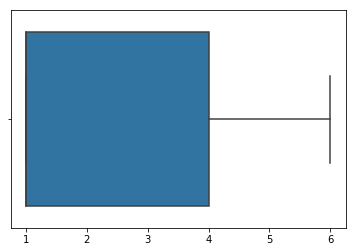

In [58]:
sns.boxplot(count_values)

In [59]:
all_columns = catboost_columns+lgbm_columns+xgbm_columns+randomforest_randomforest+extratrees_columns+gradientboosting_columns
unique_columns = list(set(all_columns))
common_columns = []
common_columns25 = []
common_columns50 = []
common_columns75 = []
N_columns = 6
count_values = [all_columns.count(col) for col in unique_columns]
for col in unique_columns:
    if all_columns.count(col)==N_columns:
        common_columns.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .25):
        common_columns25.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .5):
        common_columns50.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .75):
        common_columns75.append(col)
len(unique_columns), len(common_columns),len(common_columns25),len(common_columns50),len(common_columns75)

(53, 8, 53, 53, 16)

In [60]:
unique_columns

['5000variance_median_',
 "number_peaks{'n': 5}",
 'spkt_welch_density__coeff_3',
 '5000quantile99median_',
 'q05_roll_std_1000',
 '5000skewness_max_',
 '5000form_factor_quantile75',
 'abs_q05_6',
 '5000smoothness_std_',
 'abs_q75_6',
 'q05_5',
 'abs_q75_2',
 'abs_q95_6',
 '5000smoothness_median_',
 'median__roll_std',
 'abs_q75_7',
 '5000smoothness_quantile25',
 'q75_roll_std_10',
 '5000median_variance_',
 'abs_q25_5',
 "number_peaks{'n': 1}",
 '5000smoothness_quantile05',
 'MA_1000MA_std_mean_7',
 'iqr_6',
 '5000std_median_',
 '3th_peak_freq',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'abs_q01_5',
 'spkt_welch_density__coeff_4',
 '5000variance_quantile25',
 'q01_2',
 '5000crest_factor_quantile75',
 '5000std_quantile05',
 'q01_roll_std_10',
 'iqr_3',
 'abs_q01_3',
 '5000std_quantile25',
 'spkt_welch_densitycoeff_2',
 'q01_roll_std_1000',
 "autocorrelation{'lag': 5}",
 "value_count{'value': 1}",
 "number_peaks{'n': 3}",
 'abs_q95_2',
 "number_peaks{'n'

In [61]:
common_columns

['q05_roll_std_1000',
 'abs_q75_6',
 'abs_q25_5',
 'iqr_6',
 "number_peaks{'n': 10}",
 'q05_roll_std_100',
 'abs_q01_4',
 'q25_roll_std_100']

In [62]:
common_columns75

['spkt_welch_density__coeff_3',
 'q05_roll_std_1000',
 'abs_q75_6',
 'q05_5',
 'median__roll_std',
 'abs_q75_7',
 'abs_q25_5',
 '5000smoothness_quantile05',
 'iqr_6',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'spkt_welch_densitycoeff_2',
 "number_peaks{'n': 10}",
 'q05_roll_std_100',
 'abs_q01_4',
 'q05_roll_std_10',
 'q25_roll_std_100']

In [78]:
trial_lst = [
    df_trial_catboost.loc[452], df_trial_xgbm.loc[1172], df_trial_lgbm.loc[2156],df_trial_gradientboosting.loc[306],
             df_trial_randomforest.loc[297],df_trial_extratrees.loc[459],
#             df_trial_knn.loc[17], df_trial_svr.loc[7],df_trial_fm.loc[313],
            df_trial_lasso.loc[8], df_trial_ridge.loc[15],
            ]
name_lst = [
    'catboost452', 'xgbm1172', 'lgbm2156',
    'gradientboosting306','randomforest297','extratrees459',
#     'knn17','svr7', 'fm313',
    'lasso8','ridge15',

]

df_train_stacknet = pd.DataFrame()
df_test_stacknet = pd.DataFrame()
for df_, name_ in zip(trial_lst, name_lst):
    try:
        df_test_stacknet_i = df_['df_test_pred']
        df_test_stacknet[name_] = np.mean(df_test_stacknet_i.drop(columns=['index']).values, axis=1)
        
        df_train_stacknet_i = df_['df_valid_pred']
        df_train_stacknet[name_] = df_train_stacknet_i['predict']
        
    except Exception as e:
        print(name_, 'exception')

df_train_stacknet['index'] = df_train_stacknet_i['index']
df_train_stacknet = pd.merge(df_train_stacknet, df_train[['y','index', 'group','label']+catboost_columns], on='index')
df_test_stacknet['index'] = df_test_stacknet_i['index']
df_test_stacknet = pd.merge(df_test_stacknet, df_test[['index']+catboost_columns], on='index')

In [79]:
param = {'columns': name_lst+catboost_columns,
 'kfold': {'n_splits': 3,
  'random_state': 1985,
  'shuffle': True,
  'type': 'stratified'},#stratified
 'scaler': {'cls': 'StandardScaler'},
 'algorithm': 
         
# {'cls': 'xgb.XGBRegressor',
#  'init': {'max_depth': 3,
#   'max_bin': 38,
#   'eta': 0.27801915385245873,
#   'colsample_bytree': 0.9416983653127328,
#   'min_child_weight': 238,
#   'n_estimators': 165,
#   'subsample': 0.7471829960670435,
#   'reg_lambda': 0.6813060508093833,
#   'reg_alpha': 0.36085980027529035,
#   'n_jobs': 16},
#  'fit': {'eval_metric': 'mae', 'verbose': False, 'early_stopping_rounds': 200}},
         
         {'cls': 'cb.CatBoostRegressor',
  'init': {'num_trees': 589,
   'depth': 6,
   'learning_rate': 0.05293979792364842,
   'l2_leaf_reg': 78.065140245968,
   'bagging_temperature': 0.9302786271852079,
   'random_strength': 0.4247048326178351,
   'random_state': 651},
  'fit': {}},
         
#          {'cls': 'lgb.LGBMRegressor',
#  'init': {'learning_rate': 0.17076106120259138,
#   'feature_fraction': 0.6842101917408698,
#   'bagging_fraction': 0.8986268312800509,
#   'min_data_in_leaf': 243,
#   'lambda_l1': 4.612300279009062,
#   'lambda_l2': 97.21686371760525,
#   'max_bin': 28,
#   'num_leaves': 11,
#   'random_state': 6805,
#   'n_jobs': 32},
#  'fit': {'eval_metric': 'mae', 'verbose': False, 'early_stopping_rounds': 200}}
         
}

In [65]:
# run one try
df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train_stacknet, param, df_test = df_test_stacknet, trial=mytrial, remark='|'.join(name_lst)+'->catboost')

0:	learn: 6.4434045	total: 17.7ms	remaining: 10.4s
1:	learn: 6.1649408	total: 33.6ms	remaining: 9.87s
2:	learn: 5.9030138	total: 51.9ms	remaining: 10.1s
3:	learn: 5.6543606	total: 67.9ms	remaining: 9.93s
4:	learn: 5.4207080	total: 84.2ms	remaining: 9.84s
5:	learn: 5.2022552	total: 99.9ms	remaining: 9.71s
6:	learn: 4.9946652	total: 116ms	remaining: 9.64s
7:	learn: 4.8009723	total: 133ms	remaining: 9.64s
8:	learn: 4.6224354	total: 150ms	remaining: 9.66s
9:	learn: 4.4549856	total: 165ms	remaining: 9.56s
10:	learn: 4.2964662	total: 182ms	remaining: 9.55s
11:	learn: 4.1488726	total: 199ms	remaining: 9.59s
12:	learn: 4.0112189	total: 216ms	remaining: 9.57s
13:	learn: 3.8842444	total: 233ms	remaining: 9.57s
14:	learn: 3.7664074	total: 249ms	remaining: 9.53s
15:	learn: 3.6566320	total: 263ms	remaining: 9.41s
16:	learn: 3.5535049	total: 279ms	remaining: 9.39s
17:	learn: 3.4597162	total: 292ms	remaining: 9.27s
18:	learn: 3.3711741	total: 306ms	remaining: 9.17s
19:	learn: 3.2916581	total: 322ms	r

161:	learn: 2.3386301	total: 2.65s	remaining: 6.99s
162:	learn: 2.3378584	total: 2.67s	remaining: 6.98s
163:	learn: 2.3376520	total: 2.69s	remaining: 6.96s
164:	learn: 2.3372892	total: 2.7s	remaining: 6.94s
165:	learn: 2.3365855	total: 2.71s	remaining: 6.92s
166:	learn: 2.3362401	total: 2.73s	remaining: 6.9s
167:	learn: 2.3360646	total: 2.75s	remaining: 6.88s
168:	learn: 2.3357510	total: 2.76s	remaining: 6.87s
169:	learn: 2.3355308	total: 2.78s	remaining: 6.85s
170:	learn: 2.3352909	total: 2.8s	remaining: 6.83s
171:	learn: 2.3350429	total: 2.81s	remaining: 6.81s
172:	learn: 2.3345876	total: 2.83s	remaining: 6.79s
173:	learn: 2.3338306	total: 2.84s	remaining: 6.78s
174:	learn: 2.3332832	total: 2.86s	remaining: 6.76s
175:	learn: 2.3329340	total: 2.87s	remaining: 6.74s
176:	learn: 2.3326740	total: 2.89s	remaining: 6.72s
177:	learn: 2.3323658	total: 2.9s	remaining: 6.7s
178:	learn: 2.3321964	total: 2.92s	remaining: 6.69s
179:	learn: 2.3316980	total: 2.94s	remaining: 6.67s
180:	learn: 2.331

320:	learn: 2.2844995	total: 5.22s	remaining: 4.36s
321:	learn: 2.2843432	total: 5.24s	remaining: 4.35s
322:	learn: 2.2838038	total: 5.26s	remaining: 4.33s
323:	learn: 2.2836030	total: 5.27s	remaining: 4.31s
324:	learn: 2.2830041	total: 5.29s	remaining: 4.3s
325:	learn: 2.2828688	total: 5.3s	remaining: 4.28s
326:	learn: 2.2826517	total: 5.32s	remaining: 4.26s
327:	learn: 2.2825665	total: 5.33s	remaining: 4.25s
328:	learn: 2.2824484	total: 5.35s	remaining: 4.23s
329:	learn: 2.2823492	total: 5.37s	remaining: 4.21s
330:	learn: 2.2822483	total: 5.38s	remaining: 4.2s
331:	learn: 2.2820383	total: 5.4s	remaining: 4.18s
332:	learn: 2.2816848	total: 5.42s	remaining: 4.17s
333:	learn: 2.2813976	total: 5.43s	remaining: 4.15s
334:	learn: 2.2812928	total: 5.45s	remaining: 4.13s
335:	learn: 2.2812581	total: 5.47s	remaining: 4.12s
336:	learn: 2.2811686	total: 5.49s	remaining: 4.1s
337:	learn: 2.2809637	total: 5.5s	remaining: 4.09s
338:	learn: 2.2805368	total: 5.52s	remaining: 4.07s
339:	learn: 2.2804

479:	learn: 2.2467628	total: 7.78s	remaining: 1.77s
480:	learn: 2.2464740	total: 7.79s	remaining: 1.75s
481:	learn: 2.2463713	total: 7.81s	remaining: 1.73s
482:	learn: 2.2461890	total: 7.82s	remaining: 1.72s
483:	learn: 2.2461457	total: 7.84s	remaining: 1.7s
484:	learn: 2.2460343	total: 7.85s	remaining: 1.68s
485:	learn: 2.2459727	total: 7.87s	remaining: 1.67s
486:	learn: 2.2458521	total: 7.88s	remaining: 1.65s
487:	learn: 2.2456560	total: 7.9s	remaining: 1.63s
488:	learn: 2.2456001	total: 7.92s	remaining: 1.62s
489:	learn: 2.2453223	total: 7.93s	remaining: 1.6s
490:	learn: 2.2451387	total: 7.95s	remaining: 1.59s
491:	learn: 2.2450753	total: 7.96s	remaining: 1.57s
492:	learn: 2.2448792	total: 7.98s	remaining: 1.55s
493:	learn: 2.2444012	total: 8s	remaining: 1.54s
494:	learn: 2.2439880	total: 8.02s	remaining: 1.52s
495:	learn: 2.2438189	total: 8.03s	remaining: 1.5s
496:	learn: 2.2433693	total: 8.05s	remaining: 1.49s
497:	learn: 2.2432778	total: 8.06s	remaining: 1.47s
498:	learn: 2.24323

50:	learn: 2.4500910	total: 803ms	remaining: 8.47s
51:	learn: 2.4444859	total: 817ms	remaining: 8.44s
52:	learn: 2.4400275	total: 831ms	remaining: 8.4s
53:	learn: 2.4357667	total: 847ms	remaining: 8.39s
54:	learn: 2.4314576	total: 863ms	remaining: 8.38s
55:	learn: 2.4273623	total: 879ms	remaining: 8.37s
56:	learn: 2.4240622	total: 894ms	remaining: 8.34s
57:	learn: 2.4210440	total: 910ms	remaining: 8.33s
58:	learn: 2.4179976	total: 926ms	remaining: 8.32s
59:	learn: 2.4157246	total: 942ms	remaining: 8.3s
60:	learn: 2.4127463	total: 959ms	remaining: 8.3s
61:	learn: 2.4104574	total: 974ms	remaining: 8.28s
62:	learn: 2.4083123	total: 988ms	remaining: 8.25s
63:	learn: 2.4058292	total: 1s	remaining: 8.22s
64:	learn: 2.4038285	total: 1.02s	remaining: 8.21s
65:	learn: 2.4019068	total: 1.03s	remaining: 8.19s
66:	learn: 2.4003012	total: 1.05s	remaining: 8.18s
67:	learn: 2.3988982	total: 1.07s	remaining: 8.17s
68:	learn: 2.3965109	total: 1.08s	remaining: 8.14s
69:	learn: 2.3952491	total: 1.1s	rema

210:	learn: 2.3156910	total: 3.34s	remaining: 5.98s
211:	learn: 2.3152191	total: 3.35s	remaining: 5.96s
212:	learn: 2.3149976	total: 3.37s	remaining: 5.95s
213:	learn: 2.3143127	total: 3.38s	remaining: 5.93s
214:	learn: 2.3141287	total: 3.4s	remaining: 5.92s
215:	learn: 2.3137541	total: 3.42s	remaining: 5.9s
216:	learn: 2.3136486	total: 3.43s	remaining: 5.88s
217:	learn: 2.3131238	total: 3.45s	remaining: 5.87s
218:	learn: 2.3125220	total: 3.46s	remaining: 5.85s
219:	learn: 2.3121572	total: 3.48s	remaining: 5.84s
220:	learn: 2.3116770	total: 3.5s	remaining: 5.82s
221:	learn: 2.3116027	total: 3.51s	remaining: 5.81s
222:	learn: 2.3115218	total: 3.53s	remaining: 5.79s
223:	learn: 2.3112073	total: 3.54s	remaining: 5.78s
224:	learn: 2.3110977	total: 3.56s	remaining: 5.76s
225:	learn: 2.3108485	total: 3.57s	remaining: 5.74s
226:	learn: 2.3106373	total: 3.59s	remaining: 5.72s
227:	learn: 2.3102669	total: 3.61s	remaining: 5.71s
228:	learn: 2.3094725	total: 3.62s	remaining: 5.7s
229:	learn: 2.30

369:	learn: 2.2661872	total: 5.88s	remaining: 3.48s
370:	learn: 2.2660130	total: 5.89s	remaining: 3.46s
371:	learn: 2.2657449	total: 5.91s	remaining: 3.45s
372:	learn: 2.2655326	total: 5.92s	remaining: 3.43s
373:	learn: 2.2651718	total: 5.94s	remaining: 3.42s
374:	learn: 2.2651442	total: 5.96s	remaining: 3.4s
375:	learn: 2.2650248	total: 5.97s	remaining: 3.38s
376:	learn: 2.2647144	total: 5.99s	remaining: 3.37s
377:	learn: 2.2644451	total: 6.01s	remaining: 3.35s
378:	learn: 2.2638344	total: 6.02s	remaining: 3.34s
379:	learn: 2.2635735	total: 6.04s	remaining: 3.32s
380:	learn: 2.2634796	total: 6.05s	remaining: 3.31s
381:	learn: 2.2631692	total: 6.07s	remaining: 3.29s
382:	learn: 2.2627300	total: 6.09s	remaining: 3.27s
383:	learn: 2.2623728	total: 6.1s	remaining: 3.26s
384:	learn: 2.2623078	total: 6.12s	remaining: 3.24s
385:	learn: 2.2622316	total: 6.13s	remaining: 3.23s
386:	learn: 2.2617586	total: 6.15s	remaining: 3.21s
387:	learn: 2.2613983	total: 6.17s	remaining: 3.19s
388:	learn: 2.

528:	learn: 2.2275758	total: 8.43s	remaining: 956ms
529:	learn: 2.2273996	total: 8.45s	remaining: 941ms
530:	learn: 2.2273057	total: 8.46s	remaining: 925ms
531:	learn: 2.2271681	total: 8.48s	remaining: 909ms
532:	learn: 2.2269971	total: 8.49s	remaining: 893ms
533:	learn: 2.2269597	total: 8.51s	remaining: 877ms
534:	learn: 2.2267797	total: 8.53s	remaining: 861ms
535:	learn: 2.2265999	total: 8.54s	remaining: 845ms
536:	learn: 2.2262619	total: 8.56s	remaining: 829ms
537:	learn: 2.2261552	total: 8.57s	remaining: 813ms
538:	learn: 2.2258176	total: 8.59s	remaining: 797ms
539:	learn: 2.2256357	total: 8.61s	remaining: 781ms
540:	learn: 2.2255964	total: 8.62s	remaining: 765ms
541:	learn: 2.2252010	total: 8.64s	remaining: 749ms
542:	learn: 2.2249956	total: 8.65s	remaining: 733ms
543:	learn: 2.2248155	total: 8.67s	remaining: 717ms
544:	learn: 2.2246375	total: 8.69s	remaining: 701ms
545:	learn: 2.2244374	total: 8.7s	remaining: 685ms
546:	learn: 2.2240360	total: 8.72s	remaining: 669ms
547:	learn: 2

100:	learn: 2.3554950	total: 1.6s	remaining: 7.73s
101:	learn: 2.3548979	total: 1.61s	remaining: 7.71s
102:	learn: 2.3542765	total: 1.63s	remaining: 7.69s
103:	learn: 2.3540037	total: 1.65s	remaining: 7.68s
104:	learn: 2.3534748	total: 1.66s	remaining: 7.67s
105:	learn: 2.3527439	total: 1.68s	remaining: 7.65s
106:	learn: 2.3521022	total: 1.69s	remaining: 7.63s
107:	learn: 2.3513031	total: 1.71s	remaining: 7.6s
108:	learn: 2.3508920	total: 1.72s	remaining: 7.58s
109:	learn: 2.3502918	total: 1.74s	remaining: 7.57s
110:	learn: 2.3496392	total: 1.75s	remaining: 7.55s
111:	learn: 2.3489068	total: 1.77s	remaining: 7.54s
112:	learn: 2.3482446	total: 1.78s	remaining: 7.52s
113:	learn: 2.3476961	total: 1.8s	remaining: 7.5s
114:	learn: 2.3469815	total: 1.82s	remaining: 7.49s
115:	learn: 2.3466858	total: 1.83s	remaining: 7.48s
116:	learn: 2.3462395	total: 1.85s	remaining: 7.46s
117:	learn: 2.3459248	total: 1.86s	remaining: 7.44s
118:	learn: 2.3454355	total: 1.88s	remaining: 7.42s
119:	learn: 2.34

259:	learn: 2.2909762	total: 4.16s	remaining: 5.26s
260:	learn: 2.2905505	total: 4.17s	remaining: 5.24s
261:	learn: 2.2902532	total: 4.19s	remaining: 5.23s
262:	learn: 2.2900037	total: 4.21s	remaining: 5.21s
263:	learn: 2.2896053	total: 4.22s	remaining: 5.2s
264:	learn: 2.2894582	total: 4.24s	remaining: 5.18s
265:	learn: 2.2893635	total: 4.25s	remaining: 5.17s
266:	learn: 2.2892894	total: 4.27s	remaining: 5.15s
267:	learn: 2.2890355	total: 4.29s	remaining: 5.14s
268:	learn: 2.2886396	total: 4.3s	remaining: 5.12s
269:	learn: 2.2883550	total: 4.32s	remaining: 5.1s
270:	learn: 2.2881575	total: 4.34s	remaining: 5.09s
271:	learn: 2.2877374	total: 4.35s	remaining: 5.07s
272:	learn: 2.2873788	total: 4.37s	remaining: 5.06s
273:	learn: 2.2870434	total: 4.38s	remaining: 5.04s
274:	learn: 2.2866751	total: 4.4s	remaining: 5.03s
275:	learn: 2.2864145	total: 4.42s	remaining: 5.01s
276:	learn: 2.2862023	total: 4.43s	remaining: 4.99s
277:	learn: 2.2858013	total: 4.45s	remaining: 4.98s
278:	learn: 2.28

418:	learn: 2.2533024	total: 6.66s	remaining: 2.7s
419:	learn: 2.2532031	total: 6.68s	remaining: 2.69s
420:	learn: 2.2530689	total: 6.69s	remaining: 2.67s
421:	learn: 2.2526395	total: 6.71s	remaining: 2.65s
422:	learn: 2.2521927	total: 6.73s	remaining: 2.64s
423:	learn: 2.2519055	total: 6.74s	remaining: 2.62s
424:	learn: 2.2515848	total: 6.76s	remaining: 2.61s
425:	learn: 2.2513502	total: 6.78s	remaining: 2.59s
426:	learn: 2.2510864	total: 6.79s	remaining: 2.58s
427:	learn: 2.2509179	total: 6.81s	remaining: 2.56s
428:	learn: 2.2507387	total: 6.83s	remaining: 2.54s
429:	learn: 2.2503914	total: 6.84s	remaining: 2.53s
430:	learn: 2.2502492	total: 6.86s	remaining: 2.51s
431:	learn: 2.2501742	total: 6.87s	remaining: 2.5s
432:	learn: 2.2499035	total: 6.89s	remaining: 2.48s
433:	learn: 2.2494301	total: 6.91s	remaining: 2.47s
434:	learn: 2.2491292	total: 6.92s	remaining: 2.45s
435:	learn: 2.2487964	total: 6.94s	remaining: 2.44s
436:	learn: 2.2485847	total: 6.95s	remaining: 2.42s
437:	learn: 2.

577:	learn: 2.2202710	total: 9.17s	remaining: 175ms
578:	learn: 2.2201638	total: 9.19s	remaining: 159ms
579:	learn: 2.2201319	total: 9.2s	remaining: 143ms
580:	learn: 2.2199983	total: 9.22s	remaining: 127ms
581:	learn: 2.2197727	total: 9.23s	remaining: 111ms
582:	learn: 2.2195931	total: 9.25s	remaining: 95.2ms
583:	learn: 2.2194849	total: 9.27s	remaining: 79.3ms
584:	learn: 2.2192093	total: 9.28s	remaining: 63.5ms
585:	learn: 2.2190265	total: 9.3s	remaining: 47.6ms
586:	learn: 2.2187307	total: 9.31s	remaining: 31.7ms
587:	learn: 2.2182672	total: 9.33s	remaining: 15.9ms
588:	learn: 2.2180615	total: 9.35s	remaining: 0us


In [1]:
# EP.evaluate(df_feature_importances)
# df_feature_importances.sort_values(by=['average_model_weight'], ascending=False)

In [210]:
# EP.select_features_(df_train_stacknet, param, mytrial, df_test=df_test_stacknet, nfeats_best=1, nfeats_removed_per_try=1, key='average_model_weight')

In [24]:
# df_trial.loc[23,'remark']='catboost342|xgbm865|lgbm1398|randomforest122|extratrees250|gradientboosting83->xgbm'
# mytrial = list(df_trial.T.to_dict().values())

In [225]:
# df_trial.to_pickle('../trial/mystacknet.pkl')

In [66]:
df_trial = pd.DataFrame(mytrial)
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial[['datetime','remark', 'kfold-type', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,remark,kfold-type,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
0,2019-05-13 00:25:17.222382,None,stratified,3,1.856642,0.000010,1.863103,0.000308,0.006460
1,2019-05-13 00:29:56.214032,None,,3,1.855961,0.000007,1.863527,0.000309,0.007566
2,2019-05-13 00:33:24.920561,None,stratified,33,1.770134,0.000005,1.814401,0.000207,0.044267
3,2019-05-13 03:10:35.057918,None,stratified,3,1.851728,0.000004,1.860129,0.000447,0.008401
4,2019-05-13 03:11:42.825614,None,stratified,33,1.747469,0.000006,1.792307,0.000265,0.044838
5,2019-05-13 06:12:18.673488,None,stratified,50,1.727325,0.000010,1.780657,0.000212,0.053333
6,2019-05-13 06:25:53.650724,None,stratified,15,1.784024,0.000005,1.816030,0.000338,0.032006
7,2019-05-13 06:52:23.907165,catboost342|xgboost865|lgbm1398->catboost,stratified,33,1.744401,0.000016,1.784729,0.000220,0.040328
8,2019-05-13 07:16:06.946028,catboost342|xgboost865|lgbm1398->catboost,stratified,50,1.727243,0.000028,1.772981,0.000192,0.045737
9,2019-05-13 07:17:58.811960,catboost342|xgboost865|lgbm1398->catboost,stratified,15,1.772729,0.000010,1.803558,0.000273,0.030830


In [50]:
idx=27
df_test_pred = df_trial.loc[idx]['df_test_pred']
df_submit = pd.DataFrame()
df_submit['time_to_failure'] = np.mean(df_test_pred.drop(columns=['index']).values, axis=1)
df_submit['seg_id'] = df_test_pred['index']
df_submit.to_csv('submission_mystacknet_{}.csv'.format(idx), index=False)

In [73]:
#  tune hypterparameters
def objective(trial):
        
    num_trees = trial.suggest_int('num_trees', 200, 1000)
    depth = trial.suggest_int('depth', 2, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.4)
    l2_leaf_reg = trial.suggest_uniform('l2_leaf_reg', 0.001, 100)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', .6, 1)
    random_strength = trial.suggest_uniform('random_strength', .001, 1)
    random_state = trial.suggest_int('random_state', 1, 9999)
        
    args={
        'columns':name_lst+catboost_columns,
        'kfold':{
            'n_splits': 3,
            'random_state': 1985,
            'shuffle': True,
            'type': 'stratified'
        },
        'scaler':{
            'cls':'StandardScaler',
        },
        'algorithm':{
            'cls':'cb.CatBoostRegressor',
            'init':{
                "num_trees":num_trees,
                "depth":depth,
                "learning_rate":learning_rate,
                "l2_leaf_reg":l2_leaf_reg,
                "bagging_temperature":bagging_temperature,
                "random_strength":random_strength,
                "random_state":random_state,
            },
            'fit':{
            },
        },
    }
    
    df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train_stacknet, args, df_test = df_test_stacknet, trial=mytrial, remark='tune 30')
    val_mae_mean = np.mean(df_his.valid)
    val_mae_var = np.var(df_his.valid)
    train_mae_mean = np.mean(df_his.train)
    train_mae_var = np.var(df_his.train)
    
    trial.set_user_attr('val_mae', val_mae_mean)
    trial.set_user_attr('train_mae', train_mae_mean)
    trial.set_user_attr('mae_diff', val_mae_mean-train_mae_mean)
    trial.set_user_attr('val_mae_var', val_mae_var)

    return np.abs(val_mae_mean - train_mae_mean)*val_mae_mean

study = optuna.create_study()
study.optimize(objective, n_trials=200)

In [77]:
df_trial = pd.DataFrame(mytrial)
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial[(df_trial['remark']=='tune 30')&(df_trial['mae_diff']<.05)].sort_values(by=['val_mae'])[['datetime','remark', 'kfold-type', 'nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']].head()

,datetime,remark,kfold-type,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
174,2019-05-17 08:45:53.106273,tune 30,stratified,41,1.750823,0.000004,1.798984,0.000107,0.048161
153,2019-05-17 08:24:25.394244,tune 30,stratified,41,1.754438,0.000007,1.800232,0.000203,0.045794
133,2019-05-17 08:07:22.937737,tune 30,stratified,41,1.753582,0.000016,1.800431,0.000141,0.046849
177,2019-05-17 08:46:28.713278,tune 30,stratified,41,1.753438,0.000004,1.803042,0.000138,0.049604
190,2019-05-17 08:48:25.311136,tune 30,stratified,41,1.756542,0.000031,1.804701,0.000259,0.048159


In [ ]:
#  tune hypterparameters
def objective(trial):
        
    num_trees = trial.suggest_int('num_trees', 200, 1000)
    depth = trial.suggest_int('depth', 2, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.4)
    l2_leaf_reg = trial.suggest_uniform('l2_leaf_reg', 0.001, 100)
    bagging_temperature = trial.suggest_uniform('bagging_temperature', .6, 1)
    random_strength = trial.suggest_uniform('random_strength', .001, 1)
    random_state = trial.suggest_int('random_state', 1, 9999)
        
    args={
        'columns':name_lst+catboost_columns,
        'kfold':{
            'n_splits': 3,
            'random_state': 1985,
            'shuffle': True,
            'type': 'stratified'
        },
        'scaler':{
            'cls':'StandardScaler',
        },
        'algorithm':{
            'cls':'cb.CatBoostRegressor',
            'init':{
                "num_trees":num_trees,
                "depth":depth,
                "learning_rate":learning_rate,
                "l2_leaf_reg":l2_leaf_reg,
                "bagging_temperature":bagging_temperature,
                "random_strength":random_strength,
                "random_state":random_state,
            },
            'fit':{
            },
        },
    }
    
    df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train_stacknet, args, df_test = df_test_stacknet, trial=mytrial, remark='tune 31')
    val_mae_mean = np.mean(df_his.valid)
    val_mae_var = np.var(df_his.valid)
    train_mae_mean = np.mean(df_his.train)
    train_mae_var = np.var(df_his.train)
    
    trial.set_user_attr('val_mae', val_mae_mean)
    trial.set_user_attr('train_mae', train_mae_mean)
    trial.set_user_attr('mae_diff', val_mae_mean-train_mae_mean)
    trial.set_user_attr('val_mae_var', val_mae_var)

    return np.abs(val_mae_mean - train_mae_mean)*val_mae_mean

study = optuna.create_study()
study.optimize(objective, n_trials=200)

0:	learn: 5.4265294	total: 21.4ms	remaining: 9.74s
1:	learn: 4.4661445	total: 45.3ms	remaining: 10.3s
2:	learn: 3.7811138	total: 71.3ms	remaining: 10.8s
3:	learn: 3.3000338	total: 96.5ms	remaining: 10.9s
4:	learn: 2.9768673	total: 122ms	remaining: 11s
5:	learn: 2.7643814	total: 129ms	remaining: 9.64s
6:	learn: 2.6263042	total: 152ms	remaining: 9.72s
7:	learn: 2.5378041	total: 173ms	remaining: 9.71s
8:	learn: 2.4818184	total: 197ms	remaining: 9.79s
9:	learn: 2.4479337	total: 223ms	remaining: 9.94s
10:	learn: 2.4217944	total: 246ms	remaining: 9.94s
11:	learn: 2.4056066	total: 269ms	remaining: 9.95s
12:	learn: 2.3952368	total: 295ms	remaining: 10.1s
13:	learn: 2.3882644	total: 320ms	remaining: 10.1s
14:	learn: 2.3829153	total: 344ms	remaining: 10.1s
15:	learn: 2.3781676	total: 368ms	remaining: 10.1s
16:	learn: 2.3714120	total: 391ms	remaining: 10.1s
17:	learn: 2.3659011	total: 415ms	remaining: 10.1s
18:	learn: 2.3612322	total: 438ms	remaining: 10.1s
19:	learn: 2.3577773	total: 461ms	remai

161:	learn: 2.1901012	total: 3.89s	remaining: 7.06s
162:	learn: 2.1891511	total: 3.92s	remaining: 7.04s
163:	learn: 2.1877520	total: 3.94s	remaining: 7.02s
164:	learn: 2.1865560	total: 3.96s	remaining: 6.99s
165:	learn: 2.1861756	total: 3.99s	remaining: 6.97s
166:	learn: 2.1847315	total: 4.01s	remaining: 6.94s
167:	learn: 2.1837035	total: 4.04s	remaining: 6.92s
168:	learn: 2.1822321	total: 4.06s	remaining: 6.89s
169:	learn: 2.1812185	total: 4.08s	remaining: 6.87s
170:	learn: 2.1803705	total: 4.11s	remaining: 6.85s
171:	learn: 2.1796857	total: 4.13s	remaining: 6.83s
172:	learn: 2.1792416	total: 4.16s	remaining: 6.8s
173:	learn: 2.1779221	total: 4.18s	remaining: 6.78s
174:	learn: 2.1771282	total: 4.21s	remaining: 6.76s
175:	learn: 2.1758012	total: 4.23s	remaining: 6.74s
176:	learn: 2.1742805	total: 4.26s	remaining: 6.71s
177:	learn: 2.1736852	total: 4.28s	remaining: 6.68s
178:	learn: 2.1731007	total: 4.3s	remaining: 6.66s
179:	learn: 2.1727820	total: 4.33s	remaining: 6.63s
180:	learn: 2.

320:	learn: 2.0819613	total: 7.69s	remaining: 3.23s
321:	learn: 2.0809996	total: 7.71s	remaining: 3.21s
322:	learn: 2.0803904	total: 7.74s	remaining: 3.19s
323:	learn: 2.0798834	total: 7.76s	remaining: 3.16s
324:	learn: 2.0782548	total: 7.79s	remaining: 3.14s
325:	learn: 2.0780628	total: 7.81s	remaining: 3.11s
326:	learn: 2.0779234	total: 7.83s	remaining: 3.09s
327:	learn: 2.0776876	total: 7.86s	remaining: 3.06s
328:	learn: 2.0776261	total: 7.88s	remaining: 3.04s
329:	learn: 2.0771632	total: 7.9s	remaining: 3.02s
330:	learn: 2.0763406	total: 7.93s	remaining: 2.99s
331:	learn: 2.0763010	total: 7.95s	remaining: 2.97s
332:	learn: 2.0759889	total: 7.98s	remaining: 2.95s
333:	learn: 2.0752269	total: 8s	remaining: 2.92s
334:	learn: 2.0744646	total: 8.02s	remaining: 2.9s
335:	learn: 2.0743421	total: 8.05s	remaining: 2.88s
336:	learn: 2.0740735	total: 8.07s	remaining: 2.85s
337:	learn: 2.0738479	total: 8.1s	remaining: 2.83s
338:	learn: 2.0728994	total: 8.12s	remaining: 2.8s
339:	learn: 2.07213

23:	learn: 2.3424010	total: 585ms	remaining: 10.5s
24:	learn: 2.3398492	total: 609ms	remaining: 10.5s
25:	learn: 2.3374002	total: 634ms	remaining: 10.5s
26:	learn: 2.3352086	total: 659ms	remaining: 10.5s
27:	learn: 2.3340479	total: 683ms	remaining: 10.4s
28:	learn: 2.3321437	total: 706ms	remaining: 10.4s
29:	learn: 2.3314484	total: 729ms	remaining: 10.4s
30:	learn: 2.3290652	total: 755ms	remaining: 10.3s
31:	learn: 2.3270654	total: 779ms	remaining: 10.3s
32:	learn: 2.3259378	total: 802ms	remaining: 10.3s
33:	learn: 2.3247443	total: 825ms	remaining: 10.2s
34:	learn: 2.3224873	total: 849ms	remaining: 10.2s
35:	learn: 2.3214889	total: 874ms	remaining: 10.2s
36:	learn: 2.3190583	total: 897ms	remaining: 10.2s
37:	learn: 2.3172732	total: 923ms	remaining: 10.2s
38:	learn: 2.3159304	total: 947ms	remaining: 10.1s
39:	learn: 2.3134582	total: 971ms	remaining: 10.1s
40:	learn: 2.3123467	total: 995ms	remaining: 10.1s
41:	learn: 2.3112555	total: 1.02s	remaining: 10s
42:	learn: 2.3097350	total: 1.04s

183:	learn: 2.1749980	total: 4.5s	remaining: 6.64s
184:	learn: 2.1748771	total: 4.52s	remaining: 6.62s
185:	learn: 2.1747132	total: 4.54s	remaining: 6.6s
186:	learn: 2.1735821	total: 4.57s	remaining: 6.57s
187:	learn: 2.1717930	total: 4.59s	remaining: 6.55s
188:	learn: 2.1706815	total: 4.62s	remaining: 6.52s
189:	learn: 2.1698531	total: 4.64s	remaining: 6.5s
190:	learn: 2.1688360	total: 4.67s	remaining: 6.47s
191:	learn: 2.1680674	total: 4.69s	remaining: 6.45s
192:	learn: 2.1678013	total: 4.71s	remaining: 6.42s
193:	learn: 2.1671345	total: 4.74s	remaining: 6.4s
194:	learn: 2.1658068	total: 4.76s	remaining: 6.37s
195:	learn: 2.1643628	total: 4.79s	remaining: 6.35s
196:	learn: 2.1636481	total: 4.81s	remaining: 6.33s
197:	learn: 2.1621134	total: 4.84s	remaining: 6.3s
198:	learn: 2.1615987	total: 4.86s	remaining: 6.28s
199:	learn: 2.1589395	total: 4.89s	remaining: 6.25s
200:	learn: 2.1583641	total: 4.91s	remaining: 6.23s
201:	learn: 2.1578438	total: 4.94s	remaining: 6.21s
202:	learn: 2.157

342:	learn: 2.0931465	total: 8.33s	remaining: 2.74s
343:	learn: 2.0930637	total: 8.35s	remaining: 2.72s
344:	learn: 2.0929787	total: 8.38s	remaining: 2.69s
345:	learn: 2.0928090	total: 8.4s	remaining: 2.67s
346:	learn: 2.0927009	total: 8.42s	remaining: 2.65s
347:	learn: 2.0908856	total: 8.45s	remaining: 2.62s
348:	learn: 2.0908201	total: 8.47s	remaining: 2.6s
349:	learn: 2.0907431	total: 8.49s	remaining: 2.57s
350:	learn: 2.0904227	total: 8.52s	remaining: 2.55s
351:	learn: 2.0902860	total: 8.54s	remaining: 2.52s
352:	learn: 2.0897155	total: 8.57s	remaining: 2.5s
353:	learn: 2.0887278	total: 8.59s	remaining: 2.48s
354:	learn: 2.0877143	total: 8.62s	remaining: 2.45s
355:	learn: 2.0872186	total: 8.64s	remaining: 2.43s
356:	learn: 2.0867752	total: 8.66s	remaining: 2.4s
357:	learn: 2.0867225	total: 8.69s	remaining: 2.38s
358:	learn: 2.0865037	total: 8.71s	remaining: 2.35s
359:	learn: 2.0848928	total: 8.73s	remaining: 2.33s
360:	learn: 2.0847541	total: 8.76s	remaining: 2.3s
361:	learn: 2.084

46:	learn: 2.2924492	total: 1.14s	remaining: 9.95s
47:	learn: 2.2918499	total: 1.17s	remaining: 9.93s
48:	learn: 2.2895878	total: 1.19s	remaining: 9.91s
49:	learn: 2.2873022	total: 1.22s	remaining: 9.88s
50:	learn: 2.2850996	total: 1.24s	remaining: 9.84s
51:	learn: 2.2839283	total: 1.26s	remaining: 9.8s
52:	learn: 2.2820705	total: 1.28s	remaining: 9.76s
53:	learn: 2.2808974	total: 1.31s	remaining: 9.73s
54:	learn: 2.2780050	total: 1.33s	remaining: 9.72s
55:	learn: 2.2770830	total: 1.36s	remaining: 9.71s
56:	learn: 2.2766703	total: 1.38s	remaining: 9.66s
57:	learn: 2.2760045	total: 1.4s	remaining: 9.64s
58:	learn: 2.2737346	total: 1.43s	remaining: 9.61s
59:	learn: 2.2725589	total: 1.45s	remaining: 9.58s
60:	learn: 2.2710073	total: 1.48s	remaining: 9.55s
61:	learn: 2.2701508	total: 1.5s	remaining: 9.53s
62:	learn: 2.2682163	total: 1.52s	remaining: 9.49s
63:	learn: 2.2674708	total: 1.54s	remaining: 9.46s
64:	learn: 2.2667189	total: 1.57s	remaining: 9.45s
65:	learn: 2.2661452	total: 1.6s	r

206:	learn: 2.1323835	total: 5.01s	remaining: 6.03s
207:	learn: 2.1321395	total: 5.04s	remaining: 6s
208:	learn: 2.1315648	total: 5.06s	remaining: 5.98s
209:	learn: 2.1308314	total: 5.08s	remaining: 5.96s
210:	learn: 2.1303132	total: 5.11s	remaining: 5.93s
211:	learn: 2.1293239	total: 5.13s	remaining: 5.9s
212:	learn: 2.1289940	total: 5.15s	remaining: 5.88s
213:	learn: 2.1270173	total: 5.18s	remaining: 5.86s
214:	learn: 2.1265824	total: 5.21s	remaining: 5.83s
215:	learn: 2.1255021	total: 5.23s	remaining: 5.81s
216:	learn: 2.1244111	total: 5.26s	remaining: 5.79s
217:	learn: 2.1215037	total: 5.28s	remaining: 5.76s
218:	learn: 2.1204740	total: 5.3s	remaining: 5.74s
219:	learn: 2.1200424	total: 5.33s	remaining: 5.71s
220:	learn: 2.1196045	total: 5.35s	remaining: 5.69s
221:	learn: 2.1184593	total: 5.37s	remaining: 5.67s
222:	learn: 2.1173406	total: 5.4s	remaining: 5.64s
223:	learn: 2.1169020	total: 5.42s	remaining: 5.62s
224:	learn: 2.1159428	total: 5.45s	remaining: 5.59s
225:	learn: 2.1153

365:	learn: 2.0495438	total: 8.86s	remaining: 2.18s
366:	learn: 2.0495049	total: 8.88s	remaining: 2.15s
367:	learn: 2.0493006	total: 8.91s	remaining: 2.13s
368:	learn: 2.0484453	total: 8.93s	remaining: 2.1s
369:	learn: 2.0484040	total: 8.95s	remaining: 2.08s
370:	learn: 2.0476550	total: 8.97s	remaining: 2.06s
371:	learn: 2.0473750	total: 9s	remaining: 2.03s
372:	learn: 2.0470620	total: 9.03s	remaining: 2.01s
373:	learn: 2.0465609	total: 9.05s	remaining: 1.98s
374:	learn: 2.0460973	total: 9.08s	remaining: 1.96s
375:	learn: 2.0458377	total: 9.1s	remaining: 1.94s
376:	learn: 2.0454105	total: 9.12s	remaining: 1.91s
377:	learn: 2.0447764	total: 9.15s	remaining: 1.89s
378:	learn: 2.0439286	total: 9.17s	remaining: 1.86s
379:	learn: 2.0437005	total: 9.19s	remaining: 1.84s
380:	learn: 2.0434391	total: 9.22s	remaining: 1.81s
381:	learn: 2.0432826	total: 9.24s	remaining: 1.79s
382:	learn: 2.0429470	total: 9.27s	remaining: 1.77s
383:	learn: 2.0428829	total: 9.29s	remaining: 1.74s
384:	learn: 2.042

[I 2019-05-17 10:32:25,540] Finished a trial resulted in value: 0.2987442572091238. Current best value is 0.2987442572091238 with parameters: {'num_trees': 456, 'depth': 7, 'learning_rate': 0.23472127272586066, 'l2_leaf_reg': 92.45574130971144, 'bagging_temperature': 0.8875225928196022, 'random_strength': 0.05452765741256911, 'random_state': 5896}.


0:	learn: 6.2493247	total: 13.2ms	remaining: 12.6s
1:	learn: 5.8041480	total: 26.2ms	remaining: 12.4s
2:	learn: 5.4070186	total: 37.3ms	remaining: 11.8s
3:	learn: 5.0471890	total: 50.6ms	remaining: 12s
4:	learn: 4.7279901	total: 62ms	remaining: 11.7s
5:	learn: 4.4457067	total: 72.4ms	remaining: 11.4s
6:	learn: 4.1902331	total: 83.2ms	remaining: 11.2s
7:	learn: 3.9599885	total: 94.6ms	remaining: 11.2s
8:	learn: 3.7585872	total: 107ms	remaining: 11.2s
9:	learn: 3.5804309	total: 120ms	remaining: 11.3s
10:	learn: 3.4224195	total: 132ms	remaining: 11.3s
11:	learn: 3.2860117	total: 144ms	remaining: 11.3s
12:	learn: 3.1675132	total: 156ms	remaining: 11.3s
13:	learn: 3.0622175	total: 168ms	remaining: 11.2s
14:	learn: 2.9687031	total: 181ms	remaining: 11.3s
15:	learn: 2.8915168	total: 191ms	remaining: 11.2s
16:	learn: 2.8214836	total: 202ms	remaining: 11.1s
17:	learn: 2.7655020	total: 214ms	remaining: 11.1s
18:	learn: 2.7149569	total: 226ms	remaining: 11.1s
19:	learn: 2.6702578	total: 236ms	rem

161:	learn: 2.3082933	total: 1.83s	remaining: 8.95s
162:	learn: 2.3072021	total: 1.85s	remaining: 8.94s
163:	learn: 2.3065065	total: 1.86s	remaining: 8.93s
164:	learn: 2.3060355	total: 1.87s	remaining: 8.93s
165:	learn: 2.3053349	total: 1.88s	remaining: 8.91s
166:	learn: 2.3050251	total: 1.89s	remaining: 8.9s
167:	learn: 2.3044049	total: 1.91s	remaining: 8.89s
168:	learn: 2.3041175	total: 1.92s	remaining: 8.88s
169:	learn: 2.3033040	total: 1.93s	remaining: 8.87s
170:	learn: 2.3026019	total: 1.94s	remaining: 8.86s
171:	learn: 2.3019575	total: 1.95s	remaining: 8.84s
172:	learn: 2.3011859	total: 1.96s	remaining: 8.83s
173:	learn: 2.3005292	total: 1.97s	remaining: 8.82s
174:	learn: 2.3000383	total: 1.98s	remaining: 8.81s
175:	learn: 2.2994638	total: 2s	remaining: 8.8s
176:	learn: 2.2983711	total: 2.01s	remaining: 8.79s
177:	learn: 2.2975640	total: 2.02s	remaining: 8.78s
178:	learn: 2.2969620	total: 2.03s	remaining: 8.77s
179:	learn: 2.2964049	total: 2.04s	remaining: 8.76s
180:	learn: 2.296

320:	learn: 2.2371394	total: 3.67s	remaining: 7.22s
321:	learn: 2.2366981	total: 3.68s	remaining: 7.21s
322:	learn: 2.2364520	total: 3.69s	remaining: 7.19s
323:	learn: 2.2358935	total: 3.71s	remaining: 7.18s
324:	learn: 2.2356126	total: 3.72s	remaining: 7.17s
325:	learn: 2.2351218	total: 3.73s	remaining: 7.16s
326:	learn: 2.2346468	total: 3.74s	remaining: 7.15s
327:	learn: 2.2345650	total: 3.75s	remaining: 7.14s
328:	learn: 2.2343881	total: 3.76s	remaining: 7.13s
329:	learn: 2.2340766	total: 3.78s	remaining: 7.12s
330:	learn: 2.2338276	total: 3.79s	remaining: 7.11s
331:	learn: 2.2333692	total: 3.8s	remaining: 7.09s
332:	learn: 2.2331593	total: 3.81s	remaining: 7.08s
333:	learn: 2.2329212	total: 3.82s	remaining: 7.07s
334:	learn: 2.2327989	total: 3.83s	remaining: 7.06s
335:	learn: 2.2324778	total: 3.85s	remaining: 7.05s
336:	learn: 2.2322186	total: 3.86s	remaining: 7.04s
337:	learn: 2.2320004	total: 3.87s	remaining: 7.03s
338:	learn: 2.2318634	total: 3.88s	remaining: 7.02s
339:	learn: 2

479:	learn: 2.1929753	total: 5.49s	remaining: 5.39s
480:	learn: 2.1923819	total: 5.5s	remaining: 5.38s
481:	learn: 2.1923726	total: 5.51s	remaining: 5.37s
482:	learn: 2.1922852	total: 5.52s	remaining: 5.36s
483:	learn: 2.1921605	total: 5.53s	remaining: 5.35s
484:	learn: 2.1919302	total: 5.54s	remaining: 5.34s
485:	learn: 2.1917980	total: 5.55s	remaining: 5.33s
486:	learn: 2.1915764	total: 5.57s	remaining: 5.32s
487:	learn: 2.1911227	total: 5.58s	remaining: 5.3s
488:	learn: 2.1907613	total: 5.59s	remaining: 5.29s
489:	learn: 2.1906173	total: 5.6s	remaining: 5.28s
490:	learn: 2.1904559	total: 5.61s	remaining: 5.27s
491:	learn: 2.1896532	total: 5.62s	remaining: 5.26s
492:	learn: 2.1893418	total: 5.63s	remaining: 5.24s
493:	learn: 2.1892259	total: 5.64s	remaining: 5.23s
494:	learn: 2.1890896	total: 5.65s	remaining: 5.22s
495:	learn: 2.1888756	total: 5.67s	remaining: 5.21s
496:	learn: 2.1887202	total: 5.68s	remaining: 5.2s
497:	learn: 2.1884050	total: 5.69s	remaining: 5.19s
498:	learn: 2.18

638:	learn: 2.1595872	total: 7.31s	remaining: 3.58s
639:	learn: 2.1593091	total: 7.32s	remaining: 3.57s
640:	learn: 2.1592600	total: 7.33s	remaining: 3.56s
641:	learn: 2.1588741	total: 7.34s	remaining: 3.54s
642:	learn: 2.1587183	total: 7.35s	remaining: 3.53s
643:	learn: 2.1586673	total: 7.36s	remaining: 3.52s
644:	learn: 2.1584220	total: 7.38s	remaining: 3.51s
645:	learn: 2.1583594	total: 7.39s	remaining: 3.5s
646:	learn: 2.1577702	total: 7.4s	remaining: 3.49s
647:	learn: 2.1577359	total: 7.41s	remaining: 3.48s
648:	learn: 2.1574251	total: 7.42s	remaining: 3.46s
649:	learn: 2.1573495	total: 7.43s	remaining: 3.45s
650:	learn: 2.1573184	total: 7.44s	remaining: 3.44s
651:	learn: 2.1569438	total: 7.46s	remaining: 3.43s
652:	learn: 2.1566995	total: 7.47s	remaining: 3.42s
653:	learn: 2.1566296	total: 7.48s	remaining: 3.41s
654:	learn: 2.1565758	total: 7.49s	remaining: 3.4s
655:	learn: 2.1565141	total: 7.5s	remaining: 3.38s
656:	learn: 2.1563075	total: 7.51s	remaining: 3.37s
657:	learn: 2.15

797:	learn: 2.1297359	total: 9.11s	remaining: 1.76s
798:	learn: 2.1294472	total: 9.12s	remaining: 1.75s
799:	learn: 2.1293184	total: 9.13s	remaining: 1.74s
800:	learn: 2.1291596	total: 9.14s	remaining: 1.72s
801:	learn: 2.1289004	total: 9.15s	remaining: 1.71s
802:	learn: 2.1288056	total: 9.16s	remaining: 1.7s
803:	learn: 2.1286032	total: 9.17s	remaining: 1.69s
804:	learn: 2.1285910	total: 9.18s	remaining: 1.68s
805:	learn: 2.1284269	total: 9.2s	remaining: 1.67s
806:	learn: 2.1283988	total: 9.21s	remaining: 1.65s
807:	learn: 2.1280421	total: 9.21s	remaining: 1.64s
808:	learn: 2.1277303	total: 9.22s	remaining: 1.63s
809:	learn: 2.1276823	total: 9.23s	remaining: 1.62s
810:	learn: 2.1273185	total: 9.24s	remaining: 1.61s
811:	learn: 2.1272653	total: 9.26s	remaining: 1.59s
812:	learn: 2.1272373	total: 9.27s	remaining: 1.58s
813:	learn: 2.1271623	total: 9.28s	remaining: 1.57s
814:	learn: 2.1270118	total: 9.29s	remaining: 1.56s
815:	learn: 2.1268180	total: 9.3s	remaining: 1.55s
816:	learn: 2.1

4:	learn: 4.7322024	total: 58.2ms	remaining: 11s
5:	learn: 4.4474852	total: 69.1ms	remaining: 10.9s
6:	learn: 4.1890889	total: 81.9ms	remaining: 11.1s
7:	learn: 3.9600185	total: 93.1ms	remaining: 11s
8:	learn: 3.7569081	total: 105ms	remaining: 11s
9:	learn: 3.5788836	total: 116ms	remaining: 10.9s
10:	learn: 3.4217425	total: 126ms	remaining: 10.8s
11:	learn: 3.2844331	total: 138ms	remaining: 10.8s
12:	learn: 3.1651871	total: 150ms	remaining: 10.9s
13:	learn: 3.0591277	total: 161ms	remaining: 10.8s
14:	learn: 2.9673340	total: 171ms	remaining: 10.7s
15:	learn: 2.8901838	total: 182ms	remaining: 10.6s
16:	learn: 2.8191192	total: 192ms	remaining: 10.5s
17:	learn: 2.7636393	total: 203ms	remaining: 10.5s
18:	learn: 2.7135024	total: 215ms	remaining: 10.5s
19:	learn: 2.6687933	total: 224ms	remaining: 10.5s
20:	learn: 2.6340702	total: 236ms	remaining: 10.5s
21:	learn: 2.6021874	total: 248ms	remaining: 10.5s
22:	learn: 2.5756156	total: 260ms	remaining: 10.5s
23:	learn: 2.5510396	total: 271ms	remai

165:	learn: 2.3003177	total: 1.79s	remaining: 8.47s
166:	learn: 2.2997942	total: 1.8s	remaining: 8.46s
167:	learn: 2.2989848	total: 1.81s	remaining: 8.45s
168:	learn: 2.2987677	total: 1.82s	remaining: 8.44s
169:	learn: 2.2984303	total: 1.83s	remaining: 8.42s
170:	learn: 2.2973921	total: 1.84s	remaining: 8.42s
171:	learn: 2.2970917	total: 1.85s	remaining: 8.4s
172:	learn: 2.2962208	total: 1.86s	remaining: 8.39s
173:	learn: 2.2957112	total: 1.87s	remaining: 8.38s
174:	learn: 2.2953514	total: 1.89s	remaining: 8.37s
175:	learn: 2.2950930	total: 1.9s	remaining: 8.37s
176:	learn: 2.2944032	total: 1.91s	remaining: 8.35s
177:	learn: 2.2941502	total: 1.92s	remaining: 8.34s
178:	learn: 2.2938840	total: 1.93s	remaining: 8.33s
179:	learn: 2.2934522	total: 1.94s	remaining: 8.33s
180:	learn: 2.2928797	total: 1.95s	remaining: 8.32s
181:	learn: 2.2927467	total: 1.96s	remaining: 8.31s
182:	learn: 2.2917523	total: 1.98s	remaining: 8.3s
183:	learn: 2.2912455	total: 1.98s	remaining: 8.28s
184:	learn: 2.29

324:	learn: 2.2301735	total: 3.54s	remaining: 6.82s
325:	learn: 2.2296777	total: 3.55s	remaining: 6.81s
326:	learn: 2.2292977	total: 3.56s	remaining: 6.8s
327:	learn: 2.2289508	total: 3.57s	remaining: 6.79s
328:	learn: 2.2284875	total: 3.58s	remaining: 6.78s
329:	learn: 2.2282768	total: 3.59s	remaining: 6.77s
330:	learn: 2.2281505	total: 3.6s	remaining: 6.75s
331:	learn: 2.2279229	total: 3.61s	remaining: 6.74s
332:	learn: 2.2273072	total: 3.62s	remaining: 6.73s
333:	learn: 2.2268414	total: 3.63s	remaining: 6.71s
334:	learn: 2.2258679	total: 3.64s	remaining: 6.7s
335:	learn: 2.2256379	total: 3.65s	remaining: 6.69s
336:	learn: 2.2250681	total: 3.66s	remaining: 6.68s
337:	learn: 2.2248475	total: 3.67s	remaining: 6.67s
338:	learn: 2.2246539	total: 3.68s	remaining: 6.66s
339:	learn: 2.2244093	total: 3.69s	remaining: 6.65s
340:	learn: 2.2241864	total: 3.71s	remaining: 6.64s
341:	learn: 2.2237874	total: 3.72s	remaining: 6.63s
342:	learn: 2.2235688	total: 3.73s	remaining: 6.62s
343:	learn: 2.2

483:	learn: 2.1779459	total: 5.26s	remaining: 5.09s
484:	learn: 2.1776245	total: 5.28s	remaining: 5.08s
485:	learn: 2.1775217	total: 5.29s	remaining: 5.07s
486:	learn: 2.1768644	total: 5.3s	remaining: 5.06s
487:	learn: 2.1761380	total: 5.31s	remaining: 5.05s
488:	learn: 2.1761219	total: 5.32s	remaining: 5.03s
489:	learn: 2.1758657	total: 5.33s	remaining: 5.02s
490:	learn: 2.1757478	total: 5.34s	remaining: 5.01s
491:	learn: 2.1755638	total: 5.35s	remaining: 5s
492:	learn: 2.1753640	total: 5.36s	remaining: 4.99s
493:	learn: 2.1749542	total: 5.37s	remaining: 4.98s
494:	learn: 2.1746642	total: 5.38s	remaining: 4.97s
495:	learn: 2.1744189	total: 5.39s	remaining: 4.96s
496:	learn: 2.1740290	total: 5.4s	remaining: 4.95s
497:	learn: 2.1734348	total: 5.42s	remaining: 4.94s
498:	learn: 2.1729468	total: 5.42s	remaining: 4.92s
499:	learn: 2.1726614	total: 5.43s	remaining: 4.91s
500:	learn: 2.1722672	total: 5.45s	remaining: 4.9s
501:	learn: 2.1721623	total: 5.46s	remaining: 4.89s
502:	learn: 2.1720

642:	learn: 2.1375519	total: 6.99s	remaining: 3.36s
643:	learn: 2.1374861	total: 6.99s	remaining: 3.34s
644:	learn: 2.1372799	total: 7s	remaining: 3.33s
645:	learn: 2.1368829	total: 7.01s	remaining: 3.32s
646:	learn: 2.1365705	total: 7.03s	remaining: 3.31s
647:	learn: 2.1364655	total: 7.04s	remaining: 3.3s
648:	learn: 2.1359282	total: 7.05s	remaining: 3.29s
649:	learn: 2.1358922	total: 7.06s	remaining: 3.28s
650:	learn: 2.1354160	total: 7.07s	remaining: 3.27s
651:	learn: 2.1353513	total: 7.08s	remaining: 3.26s
652:	learn: 2.1352247	total: 7.09s	remaining: 3.25s
653:	learn: 2.1350126	total: 7.1s	remaining: 3.23s
654:	learn: 2.1349619	total: 7.11s	remaining: 3.23s
655:	learn: 2.1347481	total: 7.12s	remaining: 3.21s
656:	learn: 2.1342026	total: 7.14s	remaining: 3.2s
657:	learn: 2.1340716	total: 7.15s	remaining: 3.19s
658:	learn: 2.1339366	total: 7.16s	remaining: 3.18s
659:	learn: 2.1336067	total: 7.17s	remaining: 3.17s
660:	learn: 2.1333417	total: 7.18s	remaining: 3.16s
661:	learn: 2.1329

801:	learn: 2.1058545	total: 8.73s	remaining: 1.63s
802:	learn: 2.1058396	total: 8.74s	remaining: 1.62s
803:	learn: 2.1058119	total: 8.75s	remaining: 1.61s
804:	learn: 2.1055464	total: 8.76s	remaining: 1.6s
805:	learn: 2.1053500	total: 8.78s	remaining: 1.59s
806:	learn: 2.1052054	total: 8.79s	remaining: 1.58s
807:	learn: 2.1049501	total: 8.8s	remaining: 1.57s
808:	learn: 2.1049187	total: 8.81s	remaining: 1.56s
809:	learn: 2.1048681	total: 8.82s	remaining: 1.55s
810:	learn: 2.1046979	total: 8.83s	remaining: 1.53s
811:	learn: 2.1046418	total: 8.84s	remaining: 1.52s
812:	learn: 2.1041412	total: 8.85s	remaining: 1.51s
813:	learn: 2.1037345	total: 8.87s	remaining: 1.5s
814:	learn: 2.1035954	total: 8.88s	remaining: 1.49s
815:	learn: 2.1032219	total: 8.89s	remaining: 1.48s
816:	learn: 2.1030361	total: 8.9s	remaining: 1.47s
817:	learn: 2.1029047	total: 8.91s	remaining: 1.46s
818:	learn: 2.1025311	total: 8.92s	remaining: 1.45s
819:	learn: 2.1025154	total: 8.94s	remaining: 1.44s
820:	learn: 2.10

8:	learn: 3.7498896	total: 106ms	remaining: 11.1s
9:	learn: 3.5710111	total: 117ms	remaining: 11s
10:	learn: 3.4122584	total: 125ms	remaining: 10.7s
11:	learn: 3.2754264	total: 135ms	remaining: 10.6s
12:	learn: 3.1571439	total: 146ms	remaining: 10.6s
13:	learn: 3.0514182	total: 157ms	remaining: 10.5s
14:	learn: 2.9593393	total: 168ms	remaining: 10.5s
15:	learn: 2.8821887	total: 180ms	remaining: 10.5s
16:	learn: 2.8123618	total: 192ms	remaining: 10.6s
17:	learn: 2.7549652	total: 205ms	remaining: 10.6s
18:	learn: 2.7048220	total: 217ms	remaining: 10.6s
19:	learn: 2.6601763	total: 228ms	remaining: 10.6s
20:	learn: 2.6246270	total: 237ms	remaining: 10.5s
21:	learn: 2.5933785	total: 249ms	remaining: 10.5s
22:	learn: 2.5654446	total: 261ms	remaining: 10.5s
23:	learn: 2.5417307	total: 272ms	remaining: 10.5s
24:	learn: 2.5223978	total: 283ms	remaining: 10.5s
25:	learn: 2.5044392	total: 295ms	remaining: 10.5s
26:	learn: 2.4891608	total: 306ms	remaining: 10.5s
27:	learn: 2.4754972	total: 316ms	r

168:	learn: 2.2905190	total: 1.86s	remaining: 8.64s
169:	learn: 2.2905180	total: 1.87s	remaining: 8.61s
170:	learn: 2.2898930	total: 1.88s	remaining: 8.61s
171:	learn: 2.2892503	total: 1.89s	remaining: 8.59s
172:	learn: 2.2891880	total: 1.9s	remaining: 8.57s
173:	learn: 2.2888059	total: 1.91s	remaining: 8.55s
174:	learn: 2.2887903	total: 1.92s	remaining: 8.53s
175:	learn: 2.2877679	total: 1.93s	remaining: 8.52s
176:	learn: 2.2875882	total: 1.94s	remaining: 8.51s
177:	learn: 2.2875844	total: 1.95s	remaining: 8.49s
178:	learn: 2.2875699	total: 1.97s	remaining: 8.49s
179:	learn: 2.2869285	total: 1.98s	remaining: 8.47s
180:	learn: 2.2868560	total: 1.99s	remaining: 8.46s
181:	learn: 2.2862276	total: 2s	remaining: 8.45s
182:	learn: 2.2854441	total: 2.01s	remaining: 8.44s
183:	learn: 2.2849339	total: 2.02s	remaining: 8.45s
184:	learn: 2.2838992	total: 2.04s	remaining: 8.44s
185:	learn: 2.2832124	total: 2.05s	remaining: 8.43s
186:	learn: 2.2826977	total: 2.06s	remaining: 8.42s
187:	learn: 2.28

327:	learn: 2.2297990	total: 3.57s	remaining: 6.8s
328:	learn: 2.2292201	total: 3.58s	remaining: 6.79s
329:	learn: 2.2289099	total: 3.59s	remaining: 6.78s
330:	learn: 2.2284813	total: 3.61s	remaining: 6.76s
331:	learn: 2.2280732	total: 3.62s	remaining: 6.75s
332:	learn: 2.2275613	total: 3.63s	remaining: 6.74s
333:	learn: 2.2271460	total: 3.64s	remaining: 6.74s
334:	learn: 2.2266393	total: 3.65s	remaining: 6.72s
335:	learn: 2.2264521	total: 3.66s	remaining: 6.71s
336:	learn: 2.2261766	total: 3.67s	remaining: 6.7s
337:	learn: 2.2258532	total: 3.68s	remaining: 6.69s
338:	learn: 2.2254800	total: 3.69s	remaining: 6.68s
339:	learn: 2.2251209	total: 3.71s	remaining: 6.67s
340:	learn: 2.2244333	total: 3.72s	remaining: 6.66s
341:	learn: 2.2242037	total: 3.73s	remaining: 6.65s
342:	learn: 2.2237674	total: 3.74s	remaining: 6.64s
343:	learn: 2.2236102	total: 3.75s	remaining: 6.63s
344:	learn: 2.2235817	total: 3.76s	remaining: 6.62s
345:	learn: 2.2232096	total: 3.78s	remaining: 6.61s
346:	learn: 2.

486:	learn: 2.1837509	total: 5.31s	remaining: 5.07s
487:	learn: 2.1832452	total: 5.32s	remaining: 5.06s
488:	learn: 2.1830442	total: 5.33s	remaining: 5.05s
489:	learn: 2.1824409	total: 5.34s	remaining: 5.04s
490:	learn: 2.1822667	total: 5.35s	remaining: 5.03s
491:	learn: 2.1820371	total: 5.36s	remaining: 5.01s
492:	learn: 2.1815858	total: 5.38s	remaining: 5s
493:	learn: 2.1813185	total: 5.38s	remaining: 4.99s
494:	learn: 2.1809842	total: 5.39s	remaining: 4.98s
495:	learn: 2.1805993	total: 5.41s	remaining: 4.97s
496:	learn: 2.1801415	total: 5.42s	remaining: 4.96s
497:	learn: 2.1799105	total: 5.43s	remaining: 4.95s
498:	learn: 2.1793938	total: 5.44s	remaining: 4.94s
499:	learn: 2.1793125	total: 5.45s	remaining: 4.93s
500:	learn: 2.1786810	total: 5.46s	remaining: 4.91s
501:	learn: 2.1784170	total: 5.47s	remaining: 4.9s
502:	learn: 2.1782391	total: 5.48s	remaining: 4.89s
503:	learn: 2.1778780	total: 5.49s	remaining: 4.88s
504:	learn: 2.1771219	total: 5.5s	remaining: 4.87s
505:	learn: 2.176

645:	learn: 2.1413464	total: 7.04s	remaining: 3.33s
646:	learn: 2.1410689	total: 7.05s	remaining: 3.33s
647:	learn: 2.1405068	total: 7.06s	remaining: 3.31s
648:	learn: 2.1402914	total: 7.07s	remaining: 3.3s
649:	learn: 2.1397639	total: 7.09s	remaining: 3.29s
650:	learn: 2.1396671	total: 7.1s	remaining: 3.28s
651:	learn: 2.1390775	total: 7.11s	remaining: 3.27s
652:	learn: 2.1387149	total: 7.12s	remaining: 3.26s
653:	learn: 2.1381227	total: 7.13s	remaining: 3.25s
654:	learn: 2.1376821	total: 7.14s	remaining: 3.24s
655:	learn: 2.1374850	total: 7.15s	remaining: 3.23s
656:	learn: 2.1374312	total: 7.16s	remaining: 3.21s
657:	learn: 2.1373908	total: 7.17s	remaining: 3.2s
658:	learn: 2.1372237	total: 7.18s	remaining: 3.19s
659:	learn: 2.1371195	total: 7.19s	remaining: 3.18s
660:	learn: 2.1369130	total: 7.2s	remaining: 3.17s
661:	learn: 2.1366478	total: 7.22s	remaining: 3.16s
662:	learn: 2.1366440	total: 7.23s	remaining: 3.15s
663:	learn: 2.1365067	total: 7.24s	remaining: 3.14s
664:	learn: 2.13

804:	learn: 2.1084251	total: 8.79s	remaining: 1.6s
805:	learn: 2.1083771	total: 8.79s	remaining: 1.59s
806:	learn: 2.1083484	total: 8.81s	remaining: 1.58s
807:	learn: 2.1079748	total: 8.82s	remaining: 1.57s
808:	learn: 2.1077045	total: 8.82s	remaining: 1.56s
809:	learn: 2.1076781	total: 8.84s	remaining: 1.55s
810:	learn: 2.1076391	total: 8.85s	remaining: 1.54s
811:	learn: 2.1072092	total: 8.86s	remaining: 1.53s
812:	learn: 2.1069495	total: 8.87s	remaining: 1.52s
813:	learn: 2.1068646	total: 8.88s	remaining: 1.5s
814:	learn: 2.1063268	total: 8.89s	remaining: 1.49s
815:	learn: 2.1058648	total: 8.91s	remaining: 1.48s
816:	learn: 2.1056102	total: 8.92s	remaining: 1.47s
817:	learn: 2.1053869	total: 8.93s	remaining: 1.46s
818:	learn: 2.1051296	total: 8.94s	remaining: 1.45s
819:	learn: 2.1050291	total: 8.95s	remaining: 1.44s
820:	learn: 2.1046240	total: 8.96s	remaining: 1.43s
821:	learn: 2.1045487	total: 8.97s	remaining: 1.42s
822:	learn: 2.1041476	total: 8.98s	remaining: 1.41s
823:	learn: 2.

[I 2019-05-17 10:33:01,721] Finished a trial resulted in value: 0.22560822457637947. Current best value is 0.22560822457637947 with parameters: {'num_trees': 952, 'depth': 5, 'learning_rate': 0.08677029885071166, 'l2_leaf_reg': 34.09303106023375, 'bagging_temperature': 0.8358756097511653, 'random_strength': 0.8885378248336249, 'random_state': 8176}.


0:	learn: 4.6045291	total: 85.1ms	remaining: 1m 23s
1:	learn: 3.4384614	total: 166ms	remaining: 1m 20s
2:	learn: 2.8665619	total: 250ms	remaining: 1m 21s
3:	learn: 2.6040616	total: 341ms	remaining: 1m 22s
4:	learn: 2.4864167	total: 425ms	remaining: 1m 22s
5:	learn: 2.4319368	total: 514ms	remaining: 1m 23s
6:	learn: 2.4028841	total: 594ms	remaining: 1m 22s
7:	learn: 2.3854986	total: 674ms	remaining: 1m 21s
8:	learn: 2.3696298	total: 761ms	remaining: 1m 21s
9:	learn: 2.3613683	total: 852ms	remaining: 1m 22s
10:	learn: 2.3521575	total: 935ms	remaining: 1m 22s
11:	learn: 2.3443832	total: 1.02s	remaining: 1m 22s
12:	learn: 2.3377513	total: 1.11s	remaining: 1m 22s
13:	learn: 2.3289338	total: 1.2s	remaining: 1m 22s
14:	learn: 2.3231736	total: 1.28s	remaining: 1m 22s
15:	learn: 2.3202681	total: 1.37s	remaining: 1m 22s
16:	learn: 2.3068733	total: 1.45s	remaining: 1m 21s
17:	learn: 2.3016376	total: 1.54s	remaining: 1m 21s
18:	learn: 2.2951352	total: 1.63s	remaining: 1m 22s
19:	learn: 2.2818997	t

159:	learn: 1.8885496	total: 12.3s	remaining: 1m 2s
160:	learn: 1.8864827	total: 12.4s	remaining: 1m 2s
161:	learn: 1.8840032	total: 12.5s	remaining: 1m 2s
162:	learn: 1.8819255	total: 12.6s	remaining: 1m 2s
163:	learn: 1.8819127	total: 12.6s	remaining: 1m 2s
164:	learn: 1.8787954	total: 12.7s	remaining: 1m 2s
165:	learn: 1.8784959	total: 12.8s	remaining: 1m 2s
166:	learn: 1.8784825	total: 12.8s	remaining: 1m 2s
167:	learn: 1.8758028	total: 12.9s	remaining: 1m 2s
168:	learn: 1.8747244	total: 13s	remaining: 1m 2s
169:	learn: 1.8740846	total: 13.1s	remaining: 1m 2s
170:	learn: 1.8713905	total: 13.2s	remaining: 1m 1s
171:	learn: 1.8709435	total: 13.3s	remaining: 1m 1s
172:	learn: 1.8703428	total: 13.3s	remaining: 1m 1s
173:	learn: 1.8693887	total: 13.4s	remaining: 1m 1s
174:	learn: 1.8693847	total: 13.4s	remaining: 1m 1s
175:	learn: 1.8686827	total: 13.5s	remaining: 1m 1s
176:	learn: 1.8686799	total: 13.6s	remaining: 1m 1s
177:	learn: 1.8680319	total: 13.6s	remaining: 1m 1s
178:	learn: 1.

319:	learn: 1.7476270	total: 24.7s	remaining: 50.7s
320:	learn: 1.7475983	total: 24.8s	remaining: 50.5s
321:	learn: 1.7475852	total: 24.8s	remaining: 50.3s
322:	learn: 1.7452038	total: 24.8s	remaining: 50.2s
323:	learn: 1.7449507	total: 24.9s	remaining: 50.2s
324:	learn: 1.7449478	total: 24.9s	remaining: 50s
325:	learn: 1.7449228	total: 25s	remaining: 49.8s
326:	learn: 1.7443860	total: 25.1s	remaining: 49.7s
327:	learn: 1.7440170	total: 25.1s	remaining: 49.7s
328:	learn: 1.7439311	total: 25.2s	remaining: 49.6s
329:	learn: 1.7439198	total: 25.3s	remaining: 49.5s
330:	learn: 1.7439108	total: 25.4s	remaining: 49.5s
331:	learn: 1.7435104	total: 25.5s	remaining: 49.4s
332:	learn: 1.7422588	total: 25.6s	remaining: 49.3s
333:	learn: 1.7415490	total: 25.6s	remaining: 49.3s
334:	learn: 1.7414788	total: 25.7s	remaining: 49.2s
335:	learn: 1.7381931	total: 25.8s	remaining: 49.2s
336:	learn: 1.7381439	total: 25.9s	remaining: 49.1s
337:	learn: 1.7376789	total: 26s	remaining: 49.1s
338:	learn: 1.7374

478:	learn: 1.6728353	total: 36.7s	remaining: 38.1s
479:	learn: 1.6728219	total: 36.7s	remaining: 37.9s
480:	learn: 1.6728203	total: 36.8s	remaining: 37.8s
481:	learn: 1.6720068	total: 36.8s	remaining: 37.8s
482:	learn: 1.6717195	total: 36.9s	remaining: 37.7s
483:	learn: 1.6716725	total: 37s	remaining: 37.6s
484:	learn: 1.6682152	total: 37.1s	remaining: 37.6s
485:	learn: 1.6673106	total: 37.2s	remaining: 37.5s
486:	learn: 1.6672043	total: 37.3s	remaining: 37.4s
487:	learn: 1.6668429	total: 37.4s	remaining: 37.4s
488:	learn: 1.6634129	total: 37.5s	remaining: 37.3s
489:	learn: 1.6625055	total: 37.5s	remaining: 37.2s
490:	learn: 1.6624420	total: 37.6s	remaining: 37.2s
491:	learn: 1.6624077	total: 37.7s	remaining: 37.1s
492:	learn: 1.6623841	total: 37.8s	remaining: 37s
493:	learn: 1.6618478	total: 37.9s	remaining: 37s
494:	learn: 1.6617415	total: 38s	remaining: 36.9s
495:	learn: 1.6613281	total: 38s	remaining: 36.8s
496:	learn: 1.6612912	total: 38.1s	remaining: 36.7s
497:	learn: 1.6608090	

637:	learn: 1.6227215	total: 49s	remaining: 26s
638:	learn: 1.6224405	total: 49.1s	remaining: 25.9s
639:	learn: 1.6224147	total: 49.2s	remaining: 25.8s
640:	learn: 1.6223947	total: 49.2s	remaining: 25.7s
641:	learn: 1.6223861	total: 49.3s	remaining: 25.7s
642:	learn: 1.6219736	total: 49.4s	remaining: 25.6s
643:	learn: 1.6218463	total: 49.5s	remaining: 25.5s
644:	learn: 1.6218078	total: 49.6s	remaining: 25.4s
645:	learn: 1.6216848	total: 49.7s	remaining: 25.4s
646:	learn: 1.6216323	total: 49.7s	remaining: 25.3s
647:	learn: 1.6216184	total: 49.8s	remaining: 25.2s
648:	learn: 1.6214835	total: 49.9s	remaining: 25.2s
649:	learn: 1.6214358	total: 50s	remaining: 25.1s
650:	learn: 1.6213490	total: 50.1s	remaining: 25s
651:	learn: 1.6212032	total: 50.2s	remaining: 24.9s
652:	learn: 1.6211994	total: 50.2s	remaining: 24.8s
653:	learn: 1.6211502	total: 50.3s	remaining: 24.8s
654:	learn: 1.6208406	total: 50.4s	remaining: 24.7s
655:	learn: 1.6206247	total: 50.4s	remaining: 24.6s
656:	learn: 1.620617

797:	learn: 1.5942494	total: 1m	remaining: 13.5s
798:	learn: 1.5942349	total: 1m	remaining: 13.4s
799:	learn: 1.5942313	total: 1m	remaining: 13.3s
800:	learn: 1.5920513	total: 1m	remaining: 13.3s
801:	learn: 1.5920202	total: 1m	remaining: 13.2s
802:	learn: 1.5919254	total: 1m	remaining: 13.1s
803:	learn: 1.5894597	total: 1m	remaining: 13s
804:	learn: 1.5892910	total: 1m 1s	remaining: 13s
805:	learn: 1.5892852	total: 1m 1s	remaining: 12.9s
806:	learn: 1.5892762	total: 1m 1s	remaining: 12.8s
807:	learn: 1.5890460	total: 1m 1s	remaining: 12.7s
808:	learn: 1.5889666	total: 1m 1s	remaining: 12.7s
809:	learn: 1.5889104	total: 1m 1s	remaining: 12.6s
810:	learn: 1.5889103	total: 1m 1s	remaining: 12.5s
811:	learn: 1.5872729	total: 1m 1s	remaining: 12.4s
812:	learn: 1.5872087	total: 1m 1s	remaining: 12.3s
813:	learn: 1.5871984	total: 1m 1s	remaining: 12.3s
814:	learn: 1.5871852	total: 1m 1s	remaining: 12.2s
815:	learn: 1.5871656	total: 1m 1s	remaining: 12.1s
816:	learn: 1.5871650	total: 1m 1s	re

955:	learn: 1.5575592	total: 1m 11s	remaining: 1.5s
956:	learn: 1.5574435	total: 1m 12s	remaining: 1.43s
957:	learn: 1.5567764	total: 1m 12s	remaining: 1.35s
958:	learn: 1.5554286	total: 1m 12s	remaining: 1.28s
959:	learn: 1.5554083	total: 1m 12s	remaining: 1.21s
960:	learn: 1.5553839	total: 1m 12s	remaining: 1.13s
961:	learn: 1.5553604	total: 1m 12s	remaining: 1.05s
962:	learn: 1.5536007	total: 1m 12s	remaining: 980ms
963:	learn: 1.5535937	total: 1m 12s	remaining: 904ms
964:	learn: 1.5532738	total: 1m 12s	remaining: 829ms
965:	learn: 1.5518951	total: 1m 12s	remaining: 754ms
966:	learn: 1.5518544	total: 1m 12s	remaining: 679ms
967:	learn: 1.5500681	total: 1m 12s	remaining: 603ms
968:	learn: 1.5499852	total: 1m 13s	remaining: 528ms
969:	learn: 1.5498910	total: 1m 13s	remaining: 453ms
970:	learn: 1.5498851	total: 1m 13s	remaining: 377ms
971:	learn: 1.5488104	total: 1m 13s	remaining: 302ms
972:	learn: 1.5486812	total: 1m 13s	remaining: 226ms
973:	learn: 1.5486804	total: 1m 13s	remaining: 

137:	learn: 1.9230719	total: 11.2s	remaining: 1m 7s
138:	learn: 1.9201767	total: 11.3s	remaining: 1m 7s
139:	learn: 1.9199975	total: 11.3s	remaining: 1m 7s
140:	learn: 1.9167057	total: 11.4s	remaining: 1m 7s
141:	learn: 1.9167022	total: 11.4s	remaining: 1m 7s
142:	learn: 1.9166895	total: 11.5s	remaining: 1m 6s
143:	learn: 1.9155147	total: 11.5s	remaining: 1m 6s
144:	learn: 1.9128229	total: 11.6s	remaining: 1m 6s
145:	learn: 1.9108276	total: 11.7s	remaining: 1m 6s
146:	learn: 1.9105718	total: 11.8s	remaining: 1m 6s
147:	learn: 1.9105289	total: 11.9s	remaining: 1m 6s
148:	learn: 1.9104110	total: 12s	remaining: 1m 6s
149:	learn: 1.9062494	total: 12.1s	remaining: 1m 6s
150:	learn: 1.9061795	total: 12.1s	remaining: 1m 6s
151:	learn: 1.9050967	total: 12.2s	remaining: 1m 5s
152:	learn: 1.9048690	total: 12.2s	remaining: 1m 5s
153:	learn: 1.9026185	total: 12.3s	remaining: 1m 5s
154:	learn: 1.9022064	total: 12.4s	remaining: 1m 5s
155:	learn: 1.9021804	total: 12.5s	remaining: 1m 5s
156:	learn: 1.

297:	learn: 1.7651998	total: 23s	remaining: 52.4s
298:	learn: 1.7651172	total: 23.1s	remaining: 52.3s
299:	learn: 1.7651066	total: 23.1s	remaining: 52.1s
300:	learn: 1.7650065	total: 23.2s	remaining: 52s
301:	learn: 1.7648282	total: 23.3s	remaining: 51.9s
302:	learn: 1.7644392	total: 23.4s	remaining: 51.9s
303:	learn: 1.7630931	total: 23.5s	remaining: 51.8s
304:	learn: 1.7609542	total: 23.5s	remaining: 51.8s
305:	learn: 1.7604775	total: 23.6s	remaining: 51.7s
306:	learn: 1.7604682	total: 23.6s	remaining: 51.5s
307:	learn: 1.7604674	total: 23.7s	remaining: 51.3s
308:	learn: 1.7592733	total: 23.7s	remaining: 51.2s
309:	learn: 1.7545160	total: 23.8s	remaining: 51.2s
310:	learn: 1.7533516	total: 23.9s	remaining: 51.1s
311:	learn: 1.7530091	total: 24s	remaining: 51.1s
312:	learn: 1.7499927	total: 24.1s	remaining: 51s
313:	learn: 1.7499612	total: 24.2s	remaining: 51s
314:	learn: 1.7496983	total: 24.2s	remaining: 50.9s
315:	learn: 1.7471659	total: 24.3s	remaining: 50.8s
316:	learn: 1.7471481	

456:	learn: 1.6630641	total: 34.3s	remaining: 39s
457:	learn: 1.6619126	total: 34.4s	remaining: 38.9s
458:	learn: 1.6617969	total: 34.5s	remaining: 38.9s
459:	learn: 1.6617644	total: 34.6s	remaining: 38.8s
460:	learn: 1.6613766	total: 34.7s	remaining: 38.7s
461:	learn: 1.6602091	total: 34.8s	remaining: 38.7s
462:	learn: 1.6602031	total: 34.8s	remaining: 38.5s
463:	learn: 1.6599078	total: 34.9s	remaining: 38.5s
464:	learn: 1.6596140	total: 34.9s	remaining: 38.4s
465:	learn: 1.6593973	total: 35s	remaining: 38.3s
466:	learn: 1.6592039	total: 35.1s	remaining: 38.3s
467:	learn: 1.6590871	total: 35.2s	remaining: 38.2s
468:	learn: 1.6588127	total: 35.3s	remaining: 38.1s
469:	learn: 1.6585707	total: 35.4s	remaining: 38.1s
470:	learn: 1.6580295	total: 35.4s	remaining: 38s
471:	learn: 1.6574141	total: 35.5s	remaining: 37.9s
472:	learn: 1.6569939	total: 35.6s	remaining: 37.9s
473:	learn: 1.6568851	total: 35.7s	remaining: 37.8s
474:	learn: 1.6564583	total: 35.8s	remaining: 37.7s
475:	learn: 1.6558

615:	learn: 1.5889230	total: 45.6s	remaining: 26.7s
616:	learn: 1.5888445	total: 45.7s	remaining: 26.6s
617:	learn: 1.5886224	total: 45.8s	remaining: 26.5s
618:	learn: 1.5881526	total: 45.9s	remaining: 26.5s
619:	learn: 1.5878287	total: 46s	remaining: 26.4s
620:	learn: 1.5877002	total: 46s	remaining: 26.3s
621:	learn: 1.5876972	total: 46.1s	remaining: 26.2s
622:	learn: 1.5876956	total: 46.1s	remaining: 26.1s
623:	learn: 1.5862789	total: 46.2s	remaining: 26s
624:	learn: 1.5826461	total: 46.2s	remaining: 26s
625:	learn: 1.5826387	total: 46.3s	remaining: 25.9s
626:	learn: 1.5826366	total: 46.3s	remaining: 25.8s
627:	learn: 1.5823732	total: 46.4s	remaining: 25.7s
628:	learn: 1.5812743	total: 46.5s	remaining: 25.6s
629:	learn: 1.5808903	total: 46.5s	remaining: 25.6s
630:	learn: 1.5808796	total: 46.6s	remaining: 25.5s
631:	learn: 1.5808743	total: 46.7s	remaining: 25.4s
632:	learn: 1.5805688	total: 46.8s	remaining: 25.4s
633:	learn: 1.5797066	total: 46.9s	remaining: 25.3s
634:	learn: 1.578882

774:	learn: 1.5201743	total: 57.7s	remaining: 15s
775:	learn: 1.5200907	total: 57.8s	remaining: 14.9s
776:	learn: 1.5200326	total: 57.9s	remaining: 14.8s
777:	learn: 1.5199431	total: 58s	remaining: 14.8s
778:	learn: 1.5199195	total: 58.1s	remaining: 14.7s
779:	learn: 1.5197231	total: 58.1s	remaining: 14.6s
780:	learn: 1.5191638	total: 58.2s	remaining: 14.5s
781:	learn: 1.5191573	total: 58.3s	remaining: 14.5s
782:	learn: 1.5190293	total: 58.4s	remaining: 14.4s
783:	learn: 1.5190158	total: 58.5s	remaining: 14.3s
784:	learn: 1.5189675	total: 58.6s	remaining: 14.3s
785:	learn: 1.5186016	total: 58.7s	remaining: 14.2s
786:	learn: 1.5185260	total: 58.7s	remaining: 14.1s
787:	learn: 1.5184095	total: 58.8s	remaining: 14s
788:	learn: 1.5183858	total: 58.9s	remaining: 14s
789:	learn: 1.5176808	total: 59s	remaining: 13.9s
790:	learn: 1.5172658	total: 59.1s	remaining: 13.8s
791:	learn: 1.5172415	total: 59.2s	remaining: 13.7s
792:	learn: 1.5171387	total: 59.3s	remaining: 13.7s
793:	learn: 1.5171023	

934:	learn: 1.4780097	total: 1m 9s	remaining: 3.03s
935:	learn: 1.4776046	total: 1m 9s	remaining: 2.96s
936:	learn: 1.4776005	total: 1m 9s	remaining: 2.88s
937:	learn: 1.4773807	total: 1m 9s	remaining: 2.81s
938:	learn: 1.4773267	total: 1m 9s	remaining: 2.74s
939:	learn: 1.4768482	total: 1m 9s	remaining: 2.66s
940:	learn: 1.4753611	total: 1m 9s	remaining: 2.59s
941:	learn: 1.4753177	total: 1m 9s	remaining: 2.52s
942:	learn: 1.4751316	total: 1m 9s	remaining: 2.44s
943:	learn: 1.4751071	total: 1m 9s	remaining: 2.37s
944:	learn: 1.4751049	total: 1m 9s	remaining: 2.3s
945:	learn: 1.4750648	total: 1m 10s	remaining: 2.22s
946:	learn: 1.4748305	total: 1m 10s	remaining: 2.15s
947:	learn: 1.4747640	total: 1m 10s	remaining: 2.07s
948:	learn: 1.4747606	total: 1m 10s	remaining: 2s
949:	learn: 1.4747598	total: 1m 10s	remaining: 1.92s
950:	learn: 1.4746982	total: 1m 10s	remaining: 1.85s
951:	learn: 1.4746652	total: 1m 10s	remaining: 1.78s
952:	learn: 1.4745779	total: 1m 10s	remaining: 1.7s
953:	lear

116:	learn: 1.9229075	total: 9.28s	remaining: 1m 8s
117:	learn: 1.9227237	total: 9.32s	remaining: 1m 7s
118:	learn: 1.9202341	total: 9.4s	remaining: 1m 7s
119:	learn: 1.9169594	total: 9.49s	remaining: 1m 7s
120:	learn: 1.9169451	total: 9.5s	remaining: 1m 7s
121:	learn: 1.9162613	total: 9.59s	remaining: 1m 7s
122:	learn: 1.9155589	total: 9.68s	remaining: 1m 7s
123:	learn: 1.9132478	total: 9.76s	remaining: 1m 7s
124:	learn: 1.9075588	total: 9.85s	remaining: 1m 7s
125:	learn: 1.9057368	total: 9.93s	remaining: 1m 7s
126:	learn: 1.9038496	total: 10s	remaining: 1m 6s
127:	learn: 1.9023059	total: 10.1s	remaining: 1m 6s
128:	learn: 1.8990759	total: 10.2s	remaining: 1m 6s
129:	learn: 1.8969045	total: 10.3s	remaining: 1m 6s
130:	learn: 1.8947124	total: 10.4s	remaining: 1m 6s
131:	learn: 1.8940347	total: 10.4s	remaining: 1m 6s
132:	learn: 1.8924800	total: 10.5s	remaining: 1m 6s
133:	learn: 1.8924678	total: 10.5s	remaining: 1m 5s
134:	learn: 1.8921446	total: 10.6s	remaining: 1m 5s
135:	learn: 1.89

275:	learn: 1.7414770	total: 20.4s	remaining: 51.8s
276:	learn: 1.7412862	total: 20.5s	remaining: 51.7s
277:	learn: 1.7409374	total: 20.6s	remaining: 51.7s
278:	learn: 1.7347222	total: 20.7s	remaining: 51.7s
279:	learn: 1.7347127	total: 20.7s	remaining: 51.4s
280:	learn: 1.7338810	total: 20.8s	remaining: 51.4s
281:	learn: 1.7336303	total: 20.9s	remaining: 51.3s
282:	learn: 1.7330985	total: 20.9s	remaining: 51.3s
283:	learn: 1.7330938	total: 20.9s	remaining: 51s
284:	learn: 1.7325907	total: 21s	remaining: 51s
285:	learn: 1.7311104	total: 21.1s	remaining: 50.9s
286:	learn: 1.7282762	total: 21.2s	remaining: 50.9s
287:	learn: 1.7278232	total: 21.3s	remaining: 50.8s
288:	learn: 1.7278230	total: 21.3s	remaining: 50.6s
289:	learn: 1.7262674	total: 21.4s	remaining: 50.6s
290:	learn: 1.7262379	total: 21.5s	remaining: 50.5s
291:	learn: 1.7240965	total: 21.5s	remaining: 50.5s
292:	learn: 1.7237367	total: 21.6s	remaining: 50.4s
293:	learn: 1.7226209	total: 21.7s	remaining: 50.4s
294:	learn: 1.7226

434:	learn: 1.6410685	total: 31.2s	remaining: 38.8s
435:	learn: 1.6398146	total: 31.3s	remaining: 38.7s
436:	learn: 1.6396642	total: 31.4s	remaining: 38.7s
437:	learn: 1.6396387	total: 31.4s	remaining: 38.6s
438:	learn: 1.6396152	total: 31.5s	remaining: 38.6s
439:	learn: 1.6391258	total: 31.6s	remaining: 38.5s
440:	learn: 1.6391257	total: 31.6s	remaining: 38.4s
441:	learn: 1.6388529	total: 31.7s	remaining: 38.3s
442:	learn: 1.6387747	total: 31.8s	remaining: 38.2s
443:	learn: 1.6385758	total: 31.9s	remaining: 38.2s
444:	learn: 1.6385750	total: 31.9s	remaining: 38s
445:	learn: 1.6384825	total: 32s	remaining: 38s
446:	learn: 1.6383567	total: 32s	remaining: 37.9s
447:	learn: 1.6381259	total: 32.1s	remaining: 37.9s
448:	learn: 1.6380705	total: 32.2s	remaining: 37.8s
449:	learn: 1.6380612	total: 32.3s	remaining: 37.7s
450:	learn: 1.6376805	total: 32.3s	remaining: 37.6s
451:	learn: 1.6368359	total: 32.4s	remaining: 37.6s
452:	learn: 1.6312295	total: 32.5s	remaining: 37.5s
453:	learn: 1.631169

593:	learn: 1.5630394	total: 42.4s	remaining: 27.3s
594:	learn: 1.5629785	total: 42.5s	remaining: 27.2s
595:	learn: 1.5623910	total: 42.6s	remaining: 27.2s
596:	learn: 1.5623753	total: 42.7s	remaining: 27.1s
597:	learn: 1.5620245	total: 42.8s	remaining: 27s
598:	learn: 1.5620244	total: 42.8s	remaining: 26.9s
599:	learn: 1.5620230	total: 42.8s	remaining: 26.9s
600:	learn: 1.5620218	total: 42.9s	remaining: 26.8s
601:	learn: 1.5620218	total: 42.9s	remaining: 26.7s
602:	learn: 1.5618709	total: 43s	remaining: 26.6s
603:	learn: 1.5618568	total: 43.1s	remaining: 26.5s
604:	learn: 1.5616979	total: 43.2s	remaining: 26.5s
605:	learn: 1.5594502	total: 43.2s	remaining: 26.4s
606:	learn: 1.5594496	total: 43.3s	remaining: 26.3s
607:	learn: 1.5592694	total: 43.3s	remaining: 26.2s
608:	learn: 1.5592694	total: 43.3s	remaining: 26.1s
609:	learn: 1.5592308	total: 43.4s	remaining: 26.1s
610:	learn: 1.5591523	total: 43.5s	remaining: 26s
611:	learn: 1.5591211	total: 43.6s	remaining: 25.9s
612:	learn: 1.5591

752:	learn: 1.5195780	total: 52.9s	remaining: 15.7s
753:	learn: 1.5194101	total: 53s	remaining: 15.6s
754:	learn: 1.5193382	total: 53.1s	remaining: 15.5s
755:	learn: 1.5189558	total: 53.1s	remaining: 15.5s
756:	learn: 1.5189526	total: 53.2s	remaining: 15.4s
757:	learn: 1.5189426	total: 53.3s	remaining: 15.3s
758:	learn: 1.5189426	total: 53.3s	remaining: 15.2s
759:	learn: 1.5172320	total: 53.4s	remaining: 15.2s
760:	learn: 1.5168734	total: 53.4s	remaining: 15.1s
761:	learn: 1.5168183	total: 53.5s	remaining: 15s
762:	learn: 1.5168154	total: 53.5s	remaining: 14.9s
763:	learn: 1.5167637	total: 53.6s	remaining: 14.9s
764:	learn: 1.5166911	total: 53.7s	remaining: 14.8s
765:	learn: 1.5166910	total: 53.7s	remaining: 14.7s
766:	learn: 1.5166655	total: 53.8s	remaining: 14.6s
767:	learn: 1.5165951	total: 53.8s	remaining: 14.6s
768:	learn: 1.5165025	total: 53.9s	remaining: 14.5s
769:	learn: 1.5134688	total: 54s	remaining: 14.4s
770:	learn: 1.5129592	total: 54.1s	remaining: 14.4s
771:	learn: 1.5128

912:	learn: 1.4929158	total: 1m 4s	remaining: 4.43s
913:	learn: 1.4928815	total: 1m 4s	remaining: 4.36s
914:	learn: 1.4928549	total: 1m 4s	remaining: 4.29s
915:	learn: 1.4928235	total: 1m 4s	remaining: 4.22s
916:	learn: 1.4927284	total: 1m 4s	remaining: 4.15s
917:	learn: 1.4926574	total: 1m 4s	remaining: 4.08s
918:	learn: 1.4926115	total: 1m 4s	remaining: 4.01s
919:	learn: 1.4924121	total: 1m 4s	remaining: 3.94s
920:	learn: 1.4924094	total: 1m 4s	remaining: 3.87s
921:	learn: 1.4920625	total: 1m 4s	remaining: 3.8s
922:	learn: 1.4919659	total: 1m 5s	remaining: 3.73s
923:	learn: 1.4919237	total: 1m 5s	remaining: 3.66s
924:	learn: 1.4919146	total: 1m 5s	remaining: 3.59s
925:	learn: 1.4917585	total: 1m 5s	remaining: 3.52s
926:	learn: 1.4916347	total: 1m 5s	remaining: 3.45s
927:	learn: 1.4916284	total: 1m 5s	remaining: 3.38s
928:	learn: 1.4916275	total: 1m 5s	remaining: 3.31s
929:	learn: 1.4916086	total: 1m 5s	remaining: 3.24s
930:	learn: 1.4916026	total: 1m 5s	remaining: 3.17s
931:	learn: 1

[I 2019-05-17 10:36:42,837] Finished a trial resulted in value: 0.8500401610884184. Current best value is 0.22560822457637947 with parameters: {'num_trees': 952, 'depth': 5, 'learning_rate': 0.08677029885071166, 'l2_leaf_reg': 34.09303106023375, 'bagging_temperature': 0.8358756097511653, 'random_strength': 0.8885378248336249, 'random_state': 8176}.


0:	learn: 5.9602392	total: 24.4ms	remaining: 8.6s
1:	learn: 5.2931855	total: 49.4ms	remaining: 8.69s
2:	learn: 4.7397884	total: 73.5ms	remaining: 8.6s
3:	learn: 4.2803476	total: 100ms	remaining: 8.78s
4:	learn: 3.8991243	total: 123ms	remaining: 8.58s
5:	learn: 3.5848048	total: 148ms	remaining: 8.57s
6:	learn: 3.3374903	total: 172ms	remaining: 8.52s
7:	learn: 3.1385689	total: 198ms	remaining: 8.57s
8:	learn: 2.9794488	total: 223ms	remaining: 8.56s
9:	learn: 2.8529059	total: 245ms	remaining: 8.44s
10:	learn: 2.7523715	total: 269ms	remaining: 8.39s
11:	learn: 2.6755965	total: 291ms	remaining: 8.3s
12:	learn: 2.6194995	total: 315ms	remaining: 8.25s
13:	learn: 2.5723789	total: 337ms	remaining: 8.18s
14:	learn: 2.5377334	total: 360ms	remaining: 8.13s
15:	learn: 2.5100534	total: 383ms	remaining: 8.08s
16:	learn: 2.4897684	total: 405ms	remaining: 8.03s
17:	learn: 2.4725758	total: 429ms	remaining: 8.02s
18:	learn: 2.4581974	total: 454ms	remaining: 8s
19:	learn: 2.4455382	total: 478ms	remaining:

161:	learn: 2.2472262	total: 3.9s	remaining: 4.62s
162:	learn: 2.2461144	total: 3.92s	remaining: 4.6s
163:	learn: 2.2455337	total: 3.95s	remaining: 4.57s
164:	learn: 2.2454802	total: 3.97s	remaining: 4.55s
165:	learn: 2.2450157	total: 3.99s	remaining: 4.52s
166:	learn: 2.2449304	total: 4.02s	remaining: 4.5s
167:	learn: 2.2441697	total: 4.04s	remaining: 4.48s
168:	learn: 2.2435591	total: 4.07s	remaining: 4.45s
169:	learn: 2.2434054	total: 4.09s	remaining: 4.43s
170:	learn: 2.2427008	total: 4.12s	remaining: 4.41s
171:	learn: 2.2425993	total: 4.14s	remaining: 4.38s
172:	learn: 2.2421182	total: 4.17s	remaining: 4.36s
173:	learn: 2.2409800	total: 4.19s	remaining: 4.33s
174:	learn: 2.2394285	total: 4.21s	remaining: 4.31s
175:	learn: 2.2382442	total: 4.24s	remaining: 4.29s
176:	learn: 2.2378277	total: 4.27s	remaining: 4.27s
177:	learn: 2.2367868	total: 4.29s	remaining: 4.24s
178:	learn: 2.2367519	total: 4.31s	remaining: 4.22s
179:	learn: 2.2367116	total: 4.34s	remaining: 4.19s
180:	learn: 2.2

320:	learn: 2.1553389	total: 7.75s	remaining: 797ms
321:	learn: 2.1544592	total: 7.77s	remaining: 772ms
322:	learn: 2.1536139	total: 7.79s	remaining: 748ms
323:	learn: 2.1535640	total: 7.82s	remaining: 724ms
324:	learn: 2.1527689	total: 7.84s	remaining: 700ms
325:	learn: 2.1525191	total: 7.87s	remaining: 676ms
326:	learn: 2.1522564	total: 7.89s	remaining: 652ms
327:	learn: 2.1516102	total: 7.92s	remaining: 628ms
328:	learn: 2.1509360	total: 7.94s	remaining: 604ms
329:	learn: 2.1504977	total: 7.97s	remaining: 579ms
330:	learn: 2.1495953	total: 7.99s	remaining: 555ms
331:	learn: 2.1495726	total: 8.01s	remaining: 531ms
332:	learn: 2.1490233	total: 8.04s	remaining: 507ms
333:	learn: 2.1489213	total: 8.06s	remaining: 483ms
334:	learn: 2.1486393	total: 8.09s	remaining: 459ms
335:	learn: 2.1484012	total: 8.12s	remaining: 435ms
336:	learn: 2.1483396	total: 8.14s	remaining: 411ms
337:	learn: 2.1478664	total: 8.17s	remaining: 387ms
338:	learn: 2.1474058	total: 8.19s	remaining: 362ms
339:	learn: 

127:	learn: 2.2651489	total: 3.07s	remaining: 5.42s
128:	learn: 2.2647210	total: 3.09s	remaining: 5.39s
129:	learn: 2.2631001	total: 3.11s	remaining: 5.37s
130:	learn: 2.2621572	total: 3.14s	remaining: 5.34s
131:	learn: 2.2611396	total: 3.16s	remaining: 5.32s
132:	learn: 2.2609258	total: 3.19s	remaining: 5.3s
133:	learn: 2.2605389	total: 3.21s	remaining: 5.27s
134:	learn: 2.2589681	total: 3.23s	remaining: 5.25s
135:	learn: 2.2583168	total: 3.26s	remaining: 5.22s
136:	learn: 2.2577675	total: 3.28s	remaining: 5.2s
137:	learn: 2.2563758	total: 3.31s	remaining: 5.18s
138:	learn: 2.2552716	total: 3.33s	remaining: 5.15s
139:	learn: 2.2540467	total: 3.35s	remaining: 5.13s
140:	learn: 2.2529293	total: 3.38s	remaining: 5.1s
141:	learn: 2.2525239	total: 3.4s	remaining: 5.08s
142:	learn: 2.2517491	total: 3.43s	remaining: 5.06s
143:	learn: 2.2508446	total: 3.45s	remaining: 5.04s
144:	learn: 2.2507428	total: 3.48s	remaining: 5.01s
145:	learn: 2.2500662	total: 3.5s	remaining: 4.99s
146:	learn: 2.249

286:	learn: 2.1594348	total: 6.92s	remaining: 1.62s
287:	learn: 2.1589927	total: 6.95s	remaining: 1.59s
288:	learn: 2.1584740	total: 6.97s	remaining: 1.57s
289:	learn: 2.1576025	total: 7s	remaining: 1.54s
290:	learn: 2.1567845	total: 7.03s	remaining: 1.52s
291:	learn: 2.1566779	total: 7.05s	remaining: 1.5s
292:	learn: 2.1562648	total: 7.08s	remaining: 1.47s
293:	learn: 2.1561371	total: 7.1s	remaining: 1.45s
294:	learn: 2.1557989	total: 7.13s	remaining: 1.43s
295:	learn: 2.1552414	total: 7.15s	remaining: 1.4s
296:	learn: 2.1544661	total: 7.17s	remaining: 1.38s
297:	learn: 2.1538445	total: 7.2s	remaining: 1.35s
298:	learn: 2.1536259	total: 7.22s	remaining: 1.33s
299:	learn: 2.1534553	total: 7.25s	remaining: 1.3s
300:	learn: 2.1533434	total: 7.27s	remaining: 1.28s
301:	learn: 2.1531330	total: 7.29s	remaining: 1.26s
302:	learn: 2.1530391	total: 7.32s	remaining: 1.23s
303:	learn: 2.1524770	total: 7.34s	remaining: 1.21s
304:	learn: 2.1518791	total: 7.37s	remaining: 1.18s
305:	learn: 2.151591

92:	learn: 2.2919087	total: 2.23s	remaining: 6.25s
93:	learn: 2.2903964	total: 2.25s	remaining: 6.22s
94:	learn: 2.2893572	total: 2.27s	remaining: 6.2s
95:	learn: 2.2885874	total: 2.3s	remaining: 6.18s
96:	learn: 2.2876266	total: 2.33s	remaining: 6.17s
97:	learn: 2.2868065	total: 2.35s	remaining: 6.15s
98:	learn: 2.2853872	total: 2.38s	remaining: 6.13s
99:	learn: 2.2850944	total: 2.4s	remaining: 6.11s
100:	learn: 2.2840273	total: 2.42s	remaining: 6.08s
101:	learn: 2.2831104	total: 2.45s	remaining: 6.05s
102:	learn: 2.2823179	total: 2.47s	remaining: 6.02s
103:	learn: 2.2808587	total: 2.49s	remaining: 5.99s
104:	learn: 2.2801188	total: 2.52s	remaining: 5.97s
105:	learn: 2.2792530	total: 2.54s	remaining: 5.95s
106:	learn: 2.2783798	total: 2.57s	remaining: 5.93s
107:	learn: 2.2776154	total: 2.6s	remaining: 5.91s
108:	learn: 2.2760250	total: 2.62s	remaining: 5.88s
109:	learn: 2.2752242	total: 2.64s	remaining: 5.86s
110:	learn: 2.2746046	total: 2.67s	remaining: 5.84s
111:	learn: 2.2732172	to

251:	learn: 2.1841109	total: 6.08s	remaining: 2.46s
252:	learn: 2.1830677	total: 6.1s	remaining: 2.44s
253:	learn: 2.1823604	total: 6.13s	remaining: 2.41s
254:	learn: 2.1813400	total: 6.15s	remaining: 2.39s
255:	learn: 2.1811019	total: 6.18s	remaining: 2.37s
256:	learn: 2.1809043	total: 6.21s	remaining: 2.34s
257:	learn: 2.1801229	total: 6.23s	remaining: 2.32s
258:	learn: 2.1800140	total: 6.25s	remaining: 2.29s
259:	learn: 2.1788421	total: 6.27s	remaining: 2.27s
260:	learn: 2.1787838	total: 6.29s	remaining: 2.24s
261:	learn: 2.1781902	total: 6.31s	remaining: 2.22s
262:	learn: 2.1778740	total: 6.34s	remaining: 2.19s
263:	learn: 2.1775264	total: 6.36s	remaining: 2.17s
264:	learn: 2.1767874	total: 6.39s	remaining: 2.15s
265:	learn: 2.1766790	total: 6.42s	remaining: 2.12s
266:	learn: 2.1756548	total: 6.44s	remaining: 2.1s
267:	learn: 2.1752730	total: 6.46s	remaining: 2.07s
268:	learn: 2.1743656	total: 6.49s	remaining: 2.05s
269:	learn: 2.1738094	total: 6.51s	remaining: 2.03s
270:	learn: 2.

[I 2019-05-17 10:37:11,112] Finished a trial resulted in value: 0.1884471389397859. Current best value is 0.1884471389397859 with parameters: {'num_trees': 354, 'depth': 7, 'learning_rate': 0.14168366387200243, 'l2_leaf_reg': 73.62146877204393, 'bagging_temperature': 0.8349267781727303, 'random_strength': 0.5926997939477818, 'random_state': 1906}.


0:	learn: 5.1412003	total: 23.9ms	remaining: 6.32s
1:	learn: 4.0595136	total: 47.7ms	remaining: 6.27s
2:	learn: 3.4017400	total: 69.7ms	remaining: 6.09s
3:	learn: 2.9926583	total: 93.8ms	remaining: 6.12s
4:	learn: 2.7619457	total: 117ms	remaining: 6.08s
5:	learn: 2.6283163	total: 139ms	remaining: 6.02s
6:	learn: 2.5564666	total: 161ms	remaining: 5.92s
7:	learn: 2.5114442	total: 182ms	remaining: 5.84s
8:	learn: 2.4847238	total: 208ms	remaining: 5.91s
9:	learn: 2.4713918	total: 232ms	remaining: 5.92s
10:	learn: 2.4528480	total: 258ms	remaining: 5.97s
11:	learn: 2.4389828	total: 284ms	remaining: 6s
12:	learn: 2.4328196	total: 310ms	remaining: 6.01s
13:	learn: 2.4254006	total: 334ms	remaining: 5.99s
14:	learn: 2.4173649	total: 356ms	remaining: 5.93s
15:	learn: 2.4127081	total: 378ms	remaining: 5.88s
16:	learn: 2.4082003	total: 401ms	remaining: 5.85s
17:	learn: 2.4044002	total: 424ms	remaining: 5.82s
18:	learn: 2.4027342	total: 450ms	remaining: 5.82s
19:	learn: 2.3967252	total: 477ms	remain

161:	learn: 2.1474245	total: 3.92s	remaining: 2.49s
162:	learn: 2.1462267	total: 3.95s	remaining: 2.47s
163:	learn: 2.1461844	total: 3.97s	remaining: 2.44s
164:	learn: 2.1455015	total: 4s	remaining: 2.42s
165:	learn: 2.1442119	total: 4.02s	remaining: 2.4s
166:	learn: 2.1436160	total: 4.04s	remaining: 2.37s
167:	learn: 2.1425540	total: 4.07s	remaining: 2.35s
168:	learn: 2.1420298	total: 4.09s	remaining: 2.33s
169:	learn: 2.1417735	total: 4.12s	remaining: 2.3s
170:	learn: 2.1407867	total: 4.14s	remaining: 2.28s
171:	learn: 2.1395214	total: 4.17s	remaining: 2.25s
172:	learn: 2.1392960	total: 4.19s	remaining: 2.23s
173:	learn: 2.1385097	total: 4.21s	remaining: 2.2s
174:	learn: 2.1381429	total: 4.24s	remaining: 2.18s
175:	learn: 2.1367278	total: 4.26s	remaining: 2.15s
176:	learn: 2.1359631	total: 4.28s	remaining: 2.13s
177:	learn: 2.1359050	total: 4.31s	remaining: 2.11s
178:	learn: 2.1350429	total: 4.34s	remaining: 2.08s
179:	learn: 2.1330440	total: 4.36s	remaining: 2.06s
180:	learn: 2.1312

56:	learn: 2.2877855	total: 1.39s	remaining: 5.06s
57:	learn: 2.2850068	total: 1.41s	remaining: 5.03s
58:	learn: 2.2838137	total: 1.43s	remaining: 5.01s
59:	learn: 2.2822196	total: 1.46s	remaining: 4.97s
60:	learn: 2.2811219	total: 1.48s	remaining: 4.95s
61:	learn: 2.2799478	total: 1.5s	remaining: 4.93s
62:	learn: 2.2786913	total: 1.53s	remaining: 4.92s
63:	learn: 2.2769735	total: 1.55s	remaining: 4.89s
64:	learn: 2.2750797	total: 1.58s	remaining: 4.86s
65:	learn: 2.2727470	total: 1.6s	remaining: 4.83s
66:	learn: 2.2704960	total: 1.63s	remaining: 4.81s
67:	learn: 2.2676439	total: 1.65s	remaining: 4.79s
68:	learn: 2.2662268	total: 1.67s	remaining: 4.76s
69:	learn: 2.2638768	total: 1.7s	remaining: 4.73s
70:	learn: 2.2633354	total: 1.72s	remaining: 4.71s
71:	learn: 2.2618487	total: 1.75s	remaining: 4.69s
72:	learn: 2.2592091	total: 1.77s	remaining: 4.67s
73:	learn: 2.2571924	total: 1.8s	remaining: 4.64s
74:	learn: 2.2552202	total: 1.82s	remaining: 4.62s
75:	learn: 2.2532335	total: 1.85s	r

216:	learn: 2.0882964	total: 5.27s	remaining: 1.17s
217:	learn: 2.0878955	total: 5.29s	remaining: 1.14s
218:	learn: 2.0862483	total: 5.31s	remaining: 1.12s
219:	learn: 2.0843843	total: 5.34s	remaining: 1.09s
220:	learn: 2.0820658	total: 5.37s	remaining: 1.07s
221:	learn: 2.0815667	total: 5.4s	remaining: 1.04s
222:	learn: 2.0812115	total: 5.42s	remaining: 1.02s
223:	learn: 2.0803117	total: 5.45s	remaining: 997ms
224:	learn: 2.0797091	total: 5.47s	remaining: 973ms
225:	learn: 2.0792666	total: 5.5s	remaining: 949ms
226:	learn: 2.0792160	total: 5.52s	remaining: 925ms
227:	learn: 2.0773158	total: 5.55s	remaining: 900ms
228:	learn: 2.0761486	total: 5.57s	remaining: 876ms
229:	learn: 2.0749436	total: 5.6s	remaining: 852ms
230:	learn: 2.0739544	total: 5.63s	remaining: 828ms
231:	learn: 2.0729840	total: 5.65s	remaining: 804ms
232:	learn: 2.0718250	total: 5.67s	remaining: 779ms
233:	learn: 2.0713224	total: 5.7s	remaining: 755ms
234:	learn: 2.0711957	total: 5.72s	remaining: 730ms
235:	learn: 2.07

112:	learn: 2.1972538	total: 2.69s	remaining: 3.62s
113:	learn: 2.1971590	total: 2.72s	remaining: 3.6s
114:	learn: 2.1969641	total: 2.74s	remaining: 3.57s
115:	learn: 2.1955833	total: 2.76s	remaining: 3.55s
116:	learn: 2.1953262	total: 2.79s	remaining: 3.52s
117:	learn: 2.1940145	total: 2.81s	remaining: 3.5s
118:	learn: 2.1929571	total: 2.84s	remaining: 3.48s
119:	learn: 2.1924205	total: 2.86s	remaining: 3.46s
120:	learn: 2.1894955	total: 2.89s	remaining: 3.44s
121:	learn: 2.1869648	total: 2.91s	remaining: 3.42s
122:	learn: 2.1861429	total: 2.94s	remaining: 3.39s
123:	learn: 2.1853007	total: 2.96s	remaining: 3.37s
124:	learn: 2.1841677	total: 2.98s	remaining: 3.34s
125:	learn: 2.1832298	total: 3s	remaining: 3.31s
126:	learn: 2.1824533	total: 3.03s	remaining: 3.29s
127:	learn: 2.1802058	total: 3.06s	remaining: 3.27s
128:	learn: 2.1790661	total: 3.08s	remaining: 3.25s
129:	learn: 2.1778628	total: 3.1s	remaining: 3.22s
130:	learn: 2.1766767	total: 3.13s	remaining: 3.2s
131:	learn: 2.17577

[I 2019-05-17 10:37:32,533] Finished a trial resulted in value: 0.2661559733091866. Current best value is 0.1884471389397859 with parameters: {'num_trees': 354, 'depth': 7, 'learning_rate': 0.14168366387200243, 'l2_leaf_reg': 73.62146877204393, 'bagging_temperature': 0.8349267781727303, 'random_strength': 0.5926997939477818, 'random_state': 1906}.


0:	learn: 5.1116249	total: 4.49ms	remaining: 3.39s
1:	learn: 4.0687561	total: 10.3ms	remaining: 3.87s
2:	learn: 3.3920974	total: 14.8ms	remaining: 3.73s
3:	learn: 3.0043902	total: 20.3ms	remaining: 3.83s
4:	learn: 2.7601424	total: 25.4ms	remaining: 3.82s
5:	learn: 2.6224290	total: 31.1ms	remaining: 3.9s
6:	learn: 2.5489961	total: 36.7ms	remaining: 3.94s
7:	learn: 2.5049232	total: 41.7ms	remaining: 3.9s
8:	learn: 2.4826054	total: 46.5ms	remaining: 3.86s
9:	learn: 2.4656772	total: 52.1ms	remaining: 3.89s
10:	learn: 2.4562094	total: 59.5ms	remaining: 4.04s
11:	learn: 2.4456961	total: 64.6ms	remaining: 4.01s
12:	learn: 2.4385455	total: 69.7ms	remaining: 3.99s
13:	learn: 2.4345753	total: 75.3ms	remaining: 4s
14:	learn: 2.4294044	total: 81.8ms	remaining: 4.05s
15:	learn: 2.4267838	total: 87.6ms	remaining: 4.06s
16:	learn: 2.4235322	total: 93ms	remaining: 4.05s
17:	learn: 2.4212495	total: 99.9ms	remaining: 4.1s
18:	learn: 2.4195840	total: 106ms	remaining: 4.12s
19:	learn: 2.4153958	total: 111

160:	learn: 2.3056385	total: 843ms	remaining: 3.12s
161:	learn: 2.3050806	total: 848ms	remaining: 3.11s
162:	learn: 2.3047468	total: 854ms	remaining: 3.11s
163:	learn: 2.3039557	total: 859ms	remaining: 3.1s
164:	learn: 2.3037558	total: 864ms	remaining: 3.1s
165:	learn: 2.3034897	total: 869ms	remaining: 3.09s
166:	learn: 2.3033365	total: 873ms	remaining: 3.09s
167:	learn: 2.3029113	total: 878ms	remaining: 3.08s
168:	learn: 2.3022336	total: 884ms	remaining: 3.07s
169:	learn: 2.3021785	total: 888ms	remaining: 3.07s
170:	learn: 2.3020344	total: 893ms	remaining: 3.06s
171:	learn: 2.3013150	total: 899ms	remaining: 3.06s
172:	learn: 2.3012345	total: 903ms	remaining: 3.05s
173:	learn: 2.3011542	total: 908ms	remaining: 3.04s
174:	learn: 2.3010341	total: 913ms	remaining: 3.04s
175:	learn: 2.3006574	total: 918ms	remaining: 3.03s
176:	learn: 2.3000301	total: 923ms	remaining: 3.02s
177:	learn: 2.2994122	total: 929ms	remaining: 3.02s
178:	learn: 2.2988402	total: 934ms	remaining: 3.01s
179:	learn: 2.

319:	learn: 2.2667318	total: 1.68s	remaining: 2.3s
320:	learn: 2.2664311	total: 1.69s	remaining: 2.29s
321:	learn: 2.2663056	total: 1.69s	remaining: 2.29s
322:	learn: 2.2661923	total: 1.7s	remaining: 2.28s
323:	learn: 2.2657324	total: 1.71s	remaining: 2.28s
324:	learn: 2.2655082	total: 1.71s	remaining: 2.27s
325:	learn: 2.2652777	total: 1.72s	remaining: 2.27s
326:	learn: 2.2647882	total: 1.72s	remaining: 2.26s
327:	learn: 2.2646398	total: 1.73s	remaining: 2.26s
328:	learn: 2.2645050	total: 1.73s	remaining: 2.25s
329:	learn: 2.2640992	total: 1.74s	remaining: 2.25s
330:	learn: 2.2640729	total: 1.74s	remaining: 2.24s
331:	learn: 2.2639164	total: 1.75s	remaining: 2.24s
332:	learn: 2.2638729	total: 1.75s	remaining: 2.23s
333:	learn: 2.2636234	total: 1.76s	remaining: 2.23s
334:	learn: 2.2632357	total: 1.76s	remaining: 2.22s
335:	learn: 2.2629563	total: 1.77s	remaining: 2.22s
336:	learn: 2.2628328	total: 1.77s	remaining: 2.21s
337:	learn: 2.2626614	total: 1.78s	remaining: 2.21s
338:	learn: 2.

478:	learn: 2.2406010	total: 2.51s	remaining: 1.46s
479:	learn: 2.2403880	total: 2.52s	remaining: 1.45s
480:	learn: 2.2403820	total: 2.52s	remaining: 1.45s
481:	learn: 2.2403604	total: 2.53s	remaining: 1.44s
482:	learn: 2.2402938	total: 2.54s	remaining: 1.44s
483:	learn: 2.2402043	total: 2.54s	remaining: 1.43s
484:	learn: 2.2401110	total: 2.54s	remaining: 1.43s
485:	learn: 2.2399702	total: 2.55s	remaining: 1.42s
486:	learn: 2.2398514	total: 2.56s	remaining: 1.42s
487:	learn: 2.2397897	total: 2.56s	remaining: 1.41s
488:	learn: 2.2396129	total: 2.56s	remaining: 1.41s
489:	learn: 2.2396129	total: 2.57s	remaining: 1.4s
490:	learn: 2.2392036	total: 2.57s	remaining: 1.39s
491:	learn: 2.2391971	total: 2.58s	remaining: 1.39s
492:	learn: 2.2388632	total: 2.58s	remaining: 1.38s
493:	learn: 2.2387717	total: 2.59s	remaining: 1.38s
494:	learn: 2.2385703	total: 2.6s	remaining: 1.37s
495:	learn: 2.2385600	total: 2.6s	remaining: 1.37s
496:	learn: 2.2383883	total: 2.61s	remaining: 1.36s
497:	learn: 2.2

637:	learn: 2.2203523	total: 3.35s	remaining: 625ms
638:	learn: 2.2202483	total: 3.36s	remaining: 620ms
639:	learn: 2.2201176	total: 3.36s	remaining: 615ms
640:	learn: 2.2200644	total: 3.37s	remaining: 610ms
641:	learn: 2.2198828	total: 3.37s	remaining: 604ms
642:	learn: 2.2198251	total: 3.38s	remaining: 599ms
643:	learn: 2.2196203	total: 3.38s	remaining: 593ms
644:	learn: 2.2191870	total: 3.39s	remaining: 588ms
645:	learn: 2.2191789	total: 3.39s	remaining: 583ms
646:	learn: 2.2191784	total: 3.4s	remaining: 578ms
647:	learn: 2.2191186	total: 3.4s	remaining: 573ms
648:	learn: 2.2189837	total: 3.41s	remaining: 568ms
649:	learn: 2.2188612	total: 3.42s	remaining: 563ms
650:	learn: 2.2188483	total: 3.42s	remaining: 558ms
651:	learn: 2.2186331	total: 3.43s	remaining: 552ms
652:	learn: 2.2186254	total: 3.43s	remaining: 547ms
653:	learn: 2.2183293	total: 3.44s	remaining: 542ms
654:	learn: 2.2179149	total: 3.44s	remaining: 536ms
655:	learn: 2.2178874	total: 3.45s	remaining: 531ms
656:	learn: 2.

39:	learn: 2.3642953	total: 221ms	remaining: 3.96s
40:	learn: 2.3634963	total: 226ms	remaining: 3.95s
41:	learn: 2.3617830	total: 232ms	remaining: 3.95s
42:	learn: 2.3614540	total: 238ms	remaining: 3.95s
43:	learn: 2.3608624	total: 244ms	remaining: 3.95s
44:	learn: 2.3598237	total: 250ms	remaining: 3.95s
45:	learn: 2.3583316	total: 255ms	remaining: 3.95s
46:	learn: 2.3576429	total: 261ms	remaining: 3.94s
47:	learn: 2.3567067	total: 267ms	remaining: 3.95s
48:	learn: 2.3562590	total: 274ms	remaining: 3.95s
49:	learn: 2.3554013	total: 280ms	remaining: 3.95s
50:	learn: 2.3543271	total: 284ms	remaining: 3.94s
51:	learn: 2.3540897	total: 290ms	remaining: 3.94s
52:	learn: 2.3538069	total: 296ms	remaining: 3.93s
53:	learn: 2.3532411	total: 301ms	remaining: 3.92s
54:	learn: 2.3518962	total: 307ms	remaining: 3.92s
55:	learn: 2.3507852	total: 313ms	remaining: 3.91s
56:	learn: 2.3501243	total: 318ms	remaining: 3.9s
57:	learn: 2.3497514	total: 321ms	remaining: 3.87s
58:	learn: 2.3492219	total: 326m

199:	learn: 2.2888363	total: 1.1s	remaining: 3.07s
200:	learn: 2.2886812	total: 1.11s	remaining: 3.07s
201:	learn: 2.2884019	total: 1.11s	remaining: 3.06s
202:	learn: 2.2876359	total: 1.12s	remaining: 3.06s
203:	learn: 2.2873452	total: 1.13s	remaining: 3.05s
204:	learn: 2.2872150	total: 1.13s	remaining: 3.05s
205:	learn: 2.2869951	total: 1.14s	remaining: 3.04s
206:	learn: 2.2868645	total: 1.14s	remaining: 3.04s
207:	learn: 2.2864551	total: 1.15s	remaining: 3.03s
208:	learn: 2.2860761	total: 1.15s	remaining: 3.02s
209:	learn: 2.2859731	total: 1.16s	remaining: 3.02s
210:	learn: 2.2857251	total: 1.17s	remaining: 3.01s
211:	learn: 2.2854254	total: 1.17s	remaining: 3.01s
212:	learn: 2.2850912	total: 1.18s	remaining: 3s
213:	learn: 2.2848872	total: 1.18s	remaining: 3s
214:	learn: 2.2848833	total: 1.19s	remaining: 2.99s
215:	learn: 2.2848322	total: 1.19s	remaining: 2.99s
216:	learn: 2.2845973	total: 1.2s	remaining: 2.98s
217:	learn: 2.2842929	total: 1.2s	remaining: 2.97s
218:	learn: 2.2841671

358:	learn: 2.2528193	total: 1.98s	remaining: 2.2s
359:	learn: 2.2528128	total: 1.99s	remaining: 2.19s
360:	learn: 2.2526145	total: 1.99s	remaining: 2.19s
361:	learn: 2.2525536	total: 2s	remaining: 2.18s
362:	learn: 2.2525359	total: 2s	remaining: 2.17s
363:	learn: 2.2525342	total: 2.01s	remaining: 2.17s
364:	learn: 2.2520851	total: 2.02s	remaining: 2.17s
365:	learn: 2.2516428	total: 2.02s	remaining: 2.16s
366:	learn: 2.2512206	total: 2.03s	remaining: 2.15s
367:	learn: 2.2510083	total: 2.03s	remaining: 2.15s
368:	learn: 2.2510043	total: 2.04s	remaining: 2.14s
369:	learn: 2.2506959	total: 2.04s	remaining: 2.14s
370:	learn: 2.2500725	total: 2.05s	remaining: 2.13s
371:	learn: 2.2500647	total: 2.05s	remaining: 2.12s
372:	learn: 2.2500273	total: 2.06s	remaining: 2.12s
373:	learn: 2.2500221	total: 2.06s	remaining: 2.11s
374:	learn: 2.2499149	total: 2.07s	remaining: 2.11s
375:	learn: 2.2498359	total: 2.08s	remaining: 2.1s
376:	learn: 2.2497431	total: 2.08s	remaining: 2.1s
377:	learn: 2.2493981

517:	learn: 2.2295489	total: 2.86s	remaining: 1.32s
518:	learn: 2.2295465	total: 2.86s	remaining: 1.31s
519:	learn: 2.2295213	total: 2.87s	remaining: 1.31s
520:	learn: 2.2294646	total: 2.88s	remaining: 1.3s
521:	learn: 2.2291077	total: 2.88s	remaining: 1.3s
522:	learn: 2.2287796	total: 2.89s	remaining: 1.29s
523:	learn: 2.2287174	total: 2.9s	remaining: 1.29s
524:	learn: 2.2283990	total: 2.9s	remaining: 1.28s
525:	learn: 2.2283774	total: 2.91s	remaining: 1.28s
526:	learn: 2.2281837	total: 2.92s	remaining: 1.27s
527:	learn: 2.2279699	total: 2.92s	remaining: 1.27s
528:	learn: 2.2276866	total: 2.93s	remaining: 1.26s
529:	learn: 2.2275982	total: 2.93s	remaining: 1.25s
530:	learn: 2.2274145	total: 2.94s	remaining: 1.25s
531:	learn: 2.2273703	total: 2.94s	remaining: 1.25s
532:	learn: 2.2273682	total: 2.95s	remaining: 1.24s
533:	learn: 2.2273000	total: 2.96s	remaining: 1.23s
534:	learn: 2.2271955	total: 2.96s	remaining: 1.23s
535:	learn: 2.2269045	total: 2.96s	remaining: 1.22s
536:	learn: 2.22

676:	learn: 2.2092547	total: 3.74s	remaining: 442ms
677:	learn: 2.2091662	total: 3.74s	remaining: 436ms
678:	learn: 2.2090386	total: 3.75s	remaining: 431ms
679:	learn: 2.2088396	total: 3.75s	remaining: 425ms
680:	learn: 2.2087898	total: 3.76s	remaining: 420ms
681:	learn: 2.2087815	total: 3.77s	remaining: 414ms
682:	learn: 2.2087799	total: 3.77s	remaining: 409ms
683:	learn: 2.2087072	total: 3.78s	remaining: 403ms
684:	learn: 2.2086113	total: 3.78s	remaining: 398ms
685:	learn: 2.2083952	total: 3.79s	remaining: 392ms
686:	learn: 2.2083645	total: 3.79s	remaining: 387ms
687:	learn: 2.2083242	total: 3.8s	remaining: 381ms
688:	learn: 2.2082980	total: 3.8s	remaining: 375ms
689:	learn: 2.2082210	total: 3.81s	remaining: 370ms
690:	learn: 2.2080693	total: 3.81s	remaining: 364ms
691:	learn: 2.2080391	total: 3.82s	remaining: 359ms
692:	learn: 2.2078180	total: 3.83s	remaining: 353ms
693:	learn: 2.2075972	total: 3.83s	remaining: 348ms
694:	learn: 2.2073007	total: 3.84s	remaining: 342ms
695:	learn: 2.

79:	learn: 2.3355222	total: 439ms	remaining: 3.72s
80:	learn: 2.3350833	total: 444ms	remaining: 3.71s
81:	learn: 2.3335824	total: 450ms	remaining: 3.7s
82:	learn: 2.3324875	total: 455ms	remaining: 3.7s
83:	learn: 2.3316353	total: 460ms	remaining: 3.69s
84:	learn: 2.3312470	total: 467ms	remaining: 3.69s
85:	learn: 2.3301554	total: 472ms	remaining: 3.69s
86:	learn: 2.3295774	total: 479ms	remaining: 3.69s
87:	learn: 2.3290846	total: 486ms	remaining: 3.69s
88:	learn: 2.3283585	total: 492ms	remaining: 3.69s
89:	learn: 2.3282370	total: 499ms	remaining: 3.7s
90:	learn: 2.3274654	total: 504ms	remaining: 3.69s
91:	learn: 2.3273312	total: 510ms	remaining: 3.68s
92:	learn: 2.3269855	total: 515ms	remaining: 3.68s
93:	learn: 2.3257268	total: 523ms	remaining: 3.69s
94:	learn: 2.3254923	total: 528ms	remaining: 3.68s
95:	learn: 2.3246695	total: 533ms	remaining: 3.67s
96:	learn: 2.3242822	total: 536ms	remaining: 3.65s
97:	learn: 2.3236710	total: 542ms	remaining: 3.65s
98:	learn: 2.3234303	total: 548ms	

238:	learn: 2.2793240	total: 1.3s	remaining: 2.81s
239:	learn: 2.2791180	total: 1.3s	remaining: 2.81s
240:	learn: 2.2786121	total: 1.31s	remaining: 2.8s
241:	learn: 2.2786116	total: 1.31s	remaining: 2.8s
242:	learn: 2.2785244	total: 1.32s	remaining: 2.79s
243:	learn: 2.2784445	total: 1.32s	remaining: 2.78s
244:	learn: 2.2781973	total: 1.33s	remaining: 2.77s
245:	learn: 2.2781888	total: 1.33s	remaining: 2.77s
246:	learn: 2.2781687	total: 1.34s	remaining: 2.76s
247:	learn: 2.2778360	total: 1.34s	remaining: 2.76s
248:	learn: 2.2777924	total: 1.35s	remaining: 2.75s
249:	learn: 2.2777330	total: 1.35s	remaining: 2.75s
250:	learn: 2.2775906	total: 1.36s	remaining: 2.74s
251:	learn: 2.2772094	total: 1.37s	remaining: 2.74s
252:	learn: 2.2768240	total: 1.37s	remaining: 2.73s
253:	learn: 2.2767848	total: 1.38s	remaining: 2.73s
254:	learn: 2.2765932	total: 1.38s	remaining: 2.72s
255:	learn: 2.2764140	total: 1.39s	remaining: 2.71s
256:	learn: 2.2761217	total: 1.39s	remaining: 2.71s
257:	learn: 2.27

397:	learn: 2.2483401	total: 2.18s	remaining: 1.97s
398:	learn: 2.2483379	total: 2.19s	remaining: 1.96s
399:	learn: 2.2481961	total: 2.19s	remaining: 1.96s
400:	learn: 2.2479739	total: 2.2s	remaining: 1.95s
401:	learn: 2.2478705	total: 2.2s	remaining: 1.95s
402:	learn: 2.2478444	total: 2.21s	remaining: 1.94s
403:	learn: 2.2475910	total: 2.21s	remaining: 1.93s
404:	learn: 2.2475909	total: 2.22s	remaining: 1.93s
405:	learn: 2.2475242	total: 2.23s	remaining: 1.92s
406:	learn: 2.2474220	total: 2.23s	remaining: 1.92s
407:	learn: 2.2472670	total: 2.23s	remaining: 1.91s
408:	learn: 2.2469106	total: 2.24s	remaining: 1.91s
409:	learn: 2.2465788	total: 2.25s	remaining: 1.9s
410:	learn: 2.2463292	total: 2.25s	remaining: 1.9s
411:	learn: 2.2463073	total: 2.26s	remaining: 1.89s
412:	learn: 2.2461219	total: 2.26s	remaining: 1.89s
413:	learn: 2.2461190	total: 2.27s	remaining: 1.88s
414:	learn: 2.2461136	total: 2.27s	remaining: 1.87s
415:	learn: 2.2457551	total: 2.28s	remaining: 1.87s
416:	learn: 2.24

556:	learn: 2.2280404	total: 3.06s	remaining: 1.1s
557:	learn: 2.2278505	total: 3.07s	remaining: 1.09s
558:	learn: 2.2278361	total: 3.07s	remaining: 1.09s
559:	learn: 2.2278243	total: 3.08s	remaining: 1.08s
560:	learn: 2.2277862	total: 3.09s	remaining: 1.08s
561:	learn: 2.2277231	total: 3.09s	remaining: 1.07s
562:	learn: 2.2276651	total: 3.1s	remaining: 1.07s
563:	learn: 2.2276613	total: 3.1s	remaining: 1.06s
564:	learn: 2.2276479	total: 3.11s	remaining: 1.06s
565:	learn: 2.2273843	total: 3.12s	remaining: 1.05s
566:	learn: 2.2272546	total: 3.12s	remaining: 1.05s
567:	learn: 2.2272312	total: 3.13s	remaining: 1.04s
568:	learn: 2.2271171	total: 3.13s	remaining: 1.03s
569:	learn: 2.2271076	total: 3.14s	remaining: 1.03s
570:	learn: 2.2271065	total: 3.14s	remaining: 1.02s
571:	learn: 2.2271000	total: 3.15s	remaining: 1.02s
572:	learn: 2.2270956	total: 3.15s	remaining: 1.01s
573:	learn: 2.2270231	total: 3.16s	remaining: 1.01s
574:	learn: 2.2269102	total: 3.16s	remaining: 1s
575:	learn: 2.2267

714:	learn: 2.2119391	total: 3.94s	remaining: 232ms
715:	learn: 2.2119204	total: 3.95s	remaining: 226ms
716:	learn: 2.2116747	total: 3.95s	remaining: 221ms
717:	learn: 2.2113750	total: 3.96s	remaining: 215ms
718:	learn: 2.2113738	total: 3.97s	remaining: 210ms
719:	learn: 2.2110413	total: 3.97s	remaining: 204ms
720:	learn: 2.2109150	total: 3.98s	remaining: 199ms
721:	learn: 2.2109001	total: 3.98s	remaining: 193ms
722:	learn: 2.2106075	total: 3.99s	remaining: 188ms
723:	learn: 2.2102807	total: 4s	remaining: 182ms
724:	learn: 2.2102457	total: 4s	remaining: 177ms
725:	learn: 2.2101244	total: 4.01s	remaining: 171ms
726:	learn: 2.2101174	total: 4.01s	remaining: 166ms
727:	learn: 2.2100524	total: 4.02s	remaining: 160ms
728:	learn: 2.2098972	total: 4.02s	remaining: 154ms
729:	learn: 2.2096660	total: 4.03s	remaining: 149ms
730:	learn: 2.2092294	total: 4.03s	remaining: 143ms
731:	learn: 2.2090359	total: 4.04s	remaining: 138ms
732:	learn: 2.2089982	total: 4.04s	remaining: 132ms
733:	learn: 2.2089

[I 2019-05-17 10:37:48,235] Finished a trial resulted in value: 0.1586563419564222. Current best value is 0.1586563419564222 with parameters: {'num_trees': 757, 'depth': 2, 'learning_rate': 0.296995621677255, 'l2_leaf_reg': 50.32817771339031, 'bagging_temperature': 0.7889502158795076, 'random_strength': 0.7249752490493953, 'random_state': 1270}.


0:	learn: 4.6051165	total: 16.2ms	remaining: 10.7s
1:	learn: 3.4456758	total: 32.3ms	remaining: 10.6s
2:	learn: 2.8803021	total: 47.6ms	remaining: 10.4s
3:	learn: 2.6222354	total: 63.8ms	remaining: 10.5s
4:	learn: 2.5044102	total: 80.4ms	remaining: 10.6s
5:	learn: 2.4516748	total: 97.4ms	remaining: 10.6s
6:	learn: 2.4266230	total: 114ms	remaining: 10.7s
7:	learn: 2.4113213	total: 133ms	remaining: 10.8s
8:	learn: 2.4020743	total: 149ms	remaining: 10.8s
9:	learn: 2.3949730	total: 166ms	remaining: 10.8s
10:	learn: 2.3885556	total: 181ms	remaining: 10.7s
11:	learn: 2.3843886	total: 194ms	remaining: 10.5s
12:	learn: 2.3756657	total: 210ms	remaining: 10.5s
13:	learn: 2.3678881	total: 228ms	remaining: 10.5s
14:	learn: 2.3601106	total: 244ms	remaining: 10.5s
15:	learn: 2.3538983	total: 260ms	remaining: 10.5s
16:	learn: 2.3514872	total: 274ms	remaining: 10.4s
17:	learn: 2.3480992	total: 289ms	remaining: 10.3s
18:	learn: 2.3439891	total: 305ms	remaining: 10.3s
19:	learn: 2.3411887	total: 321ms	r

161:	learn: 2.0695255	total: 2.51s	remaining: 7.74s
162:	learn: 2.0692915	total: 2.53s	remaining: 7.73s
163:	learn: 2.0689138	total: 2.55s	remaining: 7.72s
164:	learn: 2.0666780	total: 2.56s	remaining: 7.71s
165:	learn: 2.0666469	total: 2.58s	remaining: 7.7s
166:	learn: 2.0665535	total: 2.6s	remaining: 7.68s
167:	learn: 2.0653221	total: 2.61s	remaining: 7.67s
168:	learn: 2.0653202	total: 2.62s	remaining: 7.63s
169:	learn: 2.0653195	total: 2.62s	remaining: 7.58s
170:	learn: 2.0636695	total: 2.64s	remaining: 7.57s
171:	learn: 2.0615088	total: 2.65s	remaining: 7.54s
172:	learn: 2.0614725	total: 2.67s	remaining: 7.53s
173:	learn: 2.0614513	total: 2.68s	remaining: 7.51s
174:	learn: 2.0592251	total: 2.7s	remaining: 7.5s
175:	learn: 2.0585871	total: 2.72s	remaining: 7.49s
176:	learn: 2.0582860	total: 2.74s	remaining: 7.49s
177:	learn: 2.0571692	total: 2.75s	remaining: 7.47s
178:	learn: 2.0571686	total: 2.76s	remaining: 7.43s
179:	learn: 2.0571684	total: 2.76s	remaining: 7.39s
180:	learn: 2.05

320:	learn: 1.9709250	total: 4.87s	remaining: 5.16s
321:	learn: 1.9699890	total: 4.89s	remaining: 5.14s
322:	learn: 1.9690903	total: 4.9s	remaining: 5.13s
323:	learn: 1.9683119	total: 4.92s	remaining: 5.12s
324:	learn: 1.9681162	total: 4.93s	remaining: 5.1s
325:	learn: 1.9680929	total: 4.95s	remaining: 5.08s
326:	learn: 1.9665611	total: 4.96s	remaining: 5.07s
327:	learn: 1.9660058	total: 4.98s	remaining: 5.05s
328:	learn: 1.9655708	total: 4.99s	remaining: 5.04s
329:	learn: 1.9654470	total: 5.01s	remaining: 5.03s
330:	learn: 1.9653195	total: 5.03s	remaining: 5.01s
331:	learn: 1.9652608	total: 5.05s	remaining: 5s
332:	learn: 1.9651516	total: 5.06s	remaining: 4.99s
333:	learn: 1.9646246	total: 5.08s	remaining: 4.97s
334:	learn: 1.9643114	total: 5.1s	remaining: 4.96s
335:	learn: 1.9612827	total: 5.11s	remaining: 4.95s
336:	learn: 1.9601121	total: 5.13s	remaining: 4.93s
337:	learn: 1.9600710	total: 5.14s	remaining: 4.92s
338:	learn: 1.9595875	total: 5.16s	remaining: 4.9s
339:	learn: 1.95949

479:	learn: 1.9007507	total: 7.21s	remaining: 2.72s
480:	learn: 1.9006970	total: 7.22s	remaining: 2.7s
481:	learn: 1.9006932	total: 7.24s	remaining: 2.69s
482:	learn: 1.9005546	total: 7.25s	remaining: 2.67s
483:	learn: 1.9002521	total: 7.27s	remaining: 2.66s
484:	learn: 1.9002037	total: 7.29s	remaining: 2.64s
485:	learn: 1.9001977	total: 7.3s	remaining: 2.63s
486:	learn: 1.9001977	total: 7.3s	remaining: 2.61s
487:	learn: 1.9001961	total: 7.31s	remaining: 2.59s
488:	learn: 1.8991415	total: 7.33s	remaining: 2.58s
489:	learn: 1.8991332	total: 7.34s	remaining: 2.56s
490:	learn: 1.8991309	total: 7.36s	remaining: 2.55s
491:	learn: 1.8991303	total: 7.37s	remaining: 2.53s
492:	learn: 1.8988815	total: 7.39s	remaining: 2.52s
493:	learn: 1.8964082	total: 7.4s	remaining: 2.5s
494:	learn: 1.8962447	total: 7.42s	remaining: 2.49s
495:	learn: 1.8944090	total: 7.44s	remaining: 2.47s
496:	learn: 1.8942594	total: 7.45s	remaining: 2.46s
497:	learn: 1.8942578	total: 7.47s	remaining: 2.44s
498:	learn: 1.894

638:	learn: 1.8494714	total: 9.6s	remaining: 330ms
639:	learn: 1.8489578	total: 9.62s	remaining: 316ms
640:	learn: 1.8489373	total: 9.63s	remaining: 301ms
641:	learn: 1.8489244	total: 9.65s	remaining: 286ms
642:	learn: 1.8471727	total: 9.67s	remaining: 271ms
643:	learn: 1.8471211	total: 9.69s	remaining: 256ms
644:	learn: 1.8471098	total: 9.71s	remaining: 241ms
645:	learn: 1.8470643	total: 9.72s	remaining: 226ms
646:	learn: 1.8470641	total: 9.74s	remaining: 211ms
647:	learn: 1.8470089	total: 9.75s	remaining: 196ms
648:	learn: 1.8470089	total: 9.76s	remaining: 180ms
649:	learn: 1.8464150	total: 9.77s	remaining: 165ms
650:	learn: 1.8464128	total: 9.79s	remaining: 150ms
651:	learn: 1.8460288	total: 9.8s	remaining: 135ms
652:	learn: 1.8459418	total: 9.82s	remaining: 120ms
653:	learn: 1.8445797	total: 9.84s	remaining: 105ms
654:	learn: 1.8430873	total: 9.86s	remaining: 90.3ms
655:	learn: 1.8430781	total: 9.87s	remaining: 75.2ms
656:	learn: 1.8429367	total: 9.89s	remaining: 60.2ms
657:	learn:

138:	learn: 2.0781225	total: 2.28s	remaining: 8.56s
139:	learn: 2.0772751	total: 2.3s	remaining: 8.55s
140:	learn: 2.0754768	total: 2.31s	remaining: 8.53s
141:	learn: 2.0747506	total: 2.33s	remaining: 8.51s
142:	learn: 2.0738939	total: 2.34s	remaining: 8.49s
143:	learn: 2.0732659	total: 2.36s	remaining: 8.48s
144:	learn: 2.0720789	total: 2.38s	remaining: 8.46s
145:	learn: 2.0697945	total: 2.39s	remaining: 8.44s
146:	learn: 2.0688928	total: 2.41s	remaining: 8.43s
147:	learn: 2.0688541	total: 2.43s	remaining: 8.41s
148:	learn: 2.0686061	total: 2.44s	remaining: 8.39s
149:	learn: 2.0682266	total: 2.46s	remaining: 8.38s
150:	learn: 2.0678131	total: 2.48s	remaining: 8.36s
151:	learn: 2.0667447	total: 2.49s	remaining: 8.34s
152:	learn: 2.0657288	total: 2.51s	remaining: 8.33s
153:	learn: 2.0654870	total: 2.52s	remaining: 8.31s
154:	learn: 2.0641610	total: 2.54s	remaining: 8.29s
155:	learn: 2.0640960	total: 2.56s	remaining: 8.27s
156:	learn: 2.0632123	total: 2.57s	remaining: 8.26s
157:	learn: 2

297:	learn: 1.9488069	total: 4.8s	remaining: 5.84s
298:	learn: 1.9487867	total: 4.81s	remaining: 5.83s
299:	learn: 1.9485256	total: 4.83s	remaining: 5.81s
300:	learn: 1.9469766	total: 4.84s	remaining: 5.79s
301:	learn: 1.9468392	total: 4.86s	remaining: 5.77s
302:	learn: 1.9441994	total: 4.87s	remaining: 5.76s
303:	learn: 1.9441970	total: 4.88s	remaining: 5.73s
304:	learn: 1.9432559	total: 4.9s	remaining: 5.72s
305:	learn: 1.9431364	total: 4.91s	remaining: 5.7s
306:	learn: 1.9424984	total: 4.93s	remaining: 5.68s
307:	learn: 1.9423249	total: 4.95s	remaining: 5.67s
308:	learn: 1.9418748	total: 4.96s	remaining: 5.65s
309:	learn: 1.9412854	total: 4.98s	remaining: 5.64s
310:	learn: 1.9391085	total: 4.99s	remaining: 5.62s
311:	learn: 1.9370807	total: 5.01s	remaining: 5.61s
312:	learn: 1.9369468	total: 5.03s	remaining: 5.59s
313:	learn: 1.9364903	total: 5.05s	remaining: 5.58s
314:	learn: 1.9362287	total: 5.06s	remaining: 5.56s
315:	learn: 1.9347398	total: 5.08s	remaining: 5.55s
316:	learn: 1.9

456:	learn: 1.8767781	total: 7.26s	remaining: 3.24s
457:	learn: 1.8762037	total: 7.28s	remaining: 3.23s
458:	learn: 1.8761813	total: 7.3s	remaining: 3.21s
459:	learn: 1.8761380	total: 7.31s	remaining: 3.19s
460:	learn: 1.8759937	total: 7.33s	remaining: 3.18s
461:	learn: 1.8759183	total: 7.35s	remaining: 3.16s
462:	learn: 1.8758543	total: 7.36s	remaining: 3.15s
463:	learn: 1.8756823	total: 7.38s	remaining: 3.13s
464:	learn: 1.8756233	total: 7.39s	remaining: 3.12s
465:	learn: 1.8755409	total: 7.41s	remaining: 3.1s
466:	learn: 1.8755375	total: 7.42s	remaining: 3.08s
467:	learn: 1.8753773	total: 7.44s	remaining: 3.07s
468:	learn: 1.8743658	total: 7.46s	remaining: 3.05s
469:	learn: 1.8743053	total: 7.47s	remaining: 3.04s
470:	learn: 1.8721189	total: 7.49s	remaining: 3.02s
471:	learn: 1.8721124	total: 7.51s	remaining: 3.01s
472:	learn: 1.8719276	total: 7.52s	remaining: 2.99s
473:	learn: 1.8719138	total: 7.54s	remaining: 2.97s
474:	learn: 1.8718155	total: 7.55s	remaining: 2.96s
475:	learn: 1.

615:	learn: 1.8237582	total: 9.73s	remaining: 711ms
616:	learn: 1.8237399	total: 9.74s	remaining: 695ms
617:	learn: 1.8226434	total: 9.76s	remaining: 679ms
618:	learn: 1.8226410	total: 9.78s	remaining: 664ms
619:	learn: 1.8226354	total: 9.8s	remaining: 648ms
620:	learn: 1.8225661	total: 9.81s	remaining: 632ms
621:	learn: 1.8223826	total: 9.83s	remaining: 616ms
622:	learn: 1.8218447	total: 9.84s	remaining: 600ms
623:	learn: 1.8217639	total: 9.86s	remaining: 584ms
624:	learn: 1.8212839	total: 9.87s	remaining: 569ms
625:	learn: 1.8210041	total: 9.89s	remaining: 553ms
626:	learn: 1.8207638	total: 9.9s	remaining: 537ms
627:	learn: 1.8207634	total: 9.91s	remaining: 521ms
628:	learn: 1.8202335	total: 9.92s	remaining: 505ms
629:	learn: 1.8200002	total: 9.94s	remaining: 489ms
630:	learn: 1.8199973	total: 9.95s	remaining: 473ms
631:	learn: 1.8199476	total: 9.96s	remaining: 457ms
632:	learn: 1.8198424	total: 9.98s	remaining: 441ms
633:	learn: 1.8198407	total: 9.99s	remaining: 425ms
634:	learn: 1.

114:	learn: 2.1006069	total: 1.79s	remaining: 8.52s
115:	learn: 2.1004229	total: 1.81s	remaining: 8.5s
116:	learn: 2.0984699	total: 1.83s	remaining: 8.49s
117:	learn: 2.0983323	total: 1.84s	remaining: 8.47s
118:	learn: 2.0983322	total: 1.85s	remaining: 8.41s
119:	learn: 2.0958165	total: 1.86s	remaining: 8.39s
120:	learn: 2.0944584	total: 1.88s	remaining: 8.37s
121:	learn: 2.0920758	total: 1.89s	remaining: 8.36s
122:	learn: 2.0899725	total: 1.91s	remaining: 8.34s
123:	learn: 2.0887812	total: 1.92s	remaining: 8.33s
124:	learn: 2.0872743	total: 1.94s	remaining: 8.31s
125:	learn: 2.0857210	total: 1.95s	remaining: 8.3s
126:	learn: 2.0828979	total: 1.97s	remaining: 8.28s
127:	learn: 2.0819437	total: 1.99s	remaining: 8.27s
128:	learn: 2.0786249	total: 2s	remaining: 8.26s
129:	learn: 2.0775306	total: 2.02s	remaining: 8.24s
130:	learn: 2.0763354	total: 2.03s	remaining: 8.22s
131:	learn: 2.0752175	total: 2.05s	remaining: 8.2s
132:	learn: 2.0743787	total: 2.06s	remaining: 8.18s
133:	learn: 2.0740

273:	learn: 1.9348523	total: 4.15s	remaining: 5.86s
274:	learn: 1.9348030	total: 4.15s	remaining: 5.83s
275:	learn: 1.9343425	total: 4.17s	remaining: 5.81s
276:	learn: 1.9343422	total: 4.18s	remaining: 5.79s
277:	learn: 1.9333666	total: 4.19s	remaining: 5.78s
278:	learn: 1.9332508	total: 4.21s	remaining: 5.76s
279:	learn: 1.9321673	total: 4.22s	remaining: 5.75s
280:	learn: 1.9320595	total: 4.24s	remaining: 5.73s
281:	learn: 1.9308966	total: 4.25s	remaining: 5.72s
282:	learn: 1.9301527	total: 4.27s	remaining: 5.7s
283:	learn: 1.9296176	total: 4.29s	remaining: 5.69s
284:	learn: 1.9296175	total: 4.29s	remaining: 5.66s
285:	learn: 1.9287983	total: 4.31s	remaining: 5.65s
286:	learn: 1.9285374	total: 4.32s	remaining: 5.63s
287:	learn: 1.9285131	total: 4.34s	remaining: 5.62s
288:	learn: 1.9284289	total: 4.36s	remaining: 5.61s
289:	learn: 1.9280128	total: 4.37s	remaining: 5.59s
290:	learn: 1.9264259	total: 4.39s	remaining: 5.58s
291:	learn: 1.9253887	total: 4.4s	remaining: 5.56s
292:	learn: 1.

432:	learn: 1.8487721	total: 6.49s	remaining: 3.42s
433:	learn: 1.8482977	total: 6.5s	remaining: 3.4s
434:	learn: 1.8481079	total: 6.52s	remaining: 3.39s
435:	learn: 1.8480825	total: 6.53s	remaining: 3.37s
436:	learn: 1.8479254	total: 6.55s	remaining: 3.36s
437:	learn: 1.8458188	total: 6.57s	remaining: 3.34s
438:	learn: 1.8455725	total: 6.58s	remaining: 3.33s
439:	learn: 1.8451649	total: 6.6s	remaining: 3.31s
440:	learn: 1.8451649	total: 6.6s	remaining: 3.29s
441:	learn: 1.8447088	total: 6.62s	remaining: 3.28s
442:	learn: 1.8437603	total: 6.63s	remaining: 3.26s
443:	learn: 1.8435245	total: 6.65s	remaining: 3.25s
444:	learn: 1.8433817	total: 6.66s	remaining: 3.23s
445:	learn: 1.8433697	total: 6.68s	remaining: 3.22s
446:	learn: 1.8431177	total: 6.7s	remaining: 3.21s
447:	learn: 1.8427983	total: 6.71s	remaining: 3.19s
448:	learn: 1.8427554	total: 6.73s	remaining: 3.18s
449:	learn: 1.8421282	total: 6.74s	remaining: 3.16s
450:	learn: 1.8421214	total: 6.75s	remaining: 3.15s
451:	learn: 1.842

591:	learn: 1.7830815	total: 8.82s	remaining: 1.03s
592:	learn: 1.7825412	total: 8.84s	remaining: 1.01s
593:	learn: 1.7812716	total: 8.85s	remaining: 998ms
594:	learn: 1.7812693	total: 8.86s	remaining: 983ms
595:	learn: 1.7812612	total: 8.87s	remaining: 967ms
596:	learn: 1.7811707	total: 8.88s	remaining: 952ms
597:	learn: 1.7811318	total: 8.9s	remaining: 938ms
598:	learn: 1.7810211	total: 8.91s	remaining: 923ms
599:	learn: 1.7810153	total: 8.93s	remaining: 908ms
600:	learn: 1.7808465	total: 8.95s	remaining: 893ms
601:	learn: 1.7808424	total: 8.95s	remaining: 878ms
602:	learn: 1.7807370	total: 8.97s	remaining: 863ms
603:	learn: 1.7806436	total: 8.99s	remaining: 848ms
604:	learn: 1.7794092	total: 9s	remaining: 833ms
605:	learn: 1.7793758	total: 9.02s	remaining: 818ms
606:	learn: 1.7790387	total: 9.03s	remaining: 804ms
607:	learn: 1.7781674	total: 9.05s	remaining: 789ms
608:	learn: 1.7781367	total: 9.06s	remaining: 774ms
609:	learn: 1.7775804	total: 9.08s	remaining: 759ms
610:	learn: 1.77

[I 2019-05-17 10:38:22,125] Finished a trial resulted in value: 0.5504473808308389. Current best value is 0.1586563419564222 with parameters: {'num_trees': 757, 'depth': 2, 'learning_rate': 0.296995621677255, 'l2_leaf_reg': 50.32817771339031, 'bagging_temperature': 0.7889502158795076, 'random_strength': 0.7249752490493953, 'random_state': 1270}.


0:	learn: 5.5333449	total: 8.79ms	remaining: 3.14s
1:	learn: 4.6234398	total: 17.2ms	remaining: 3.07s
2:	learn: 3.9502427	total: 25.6ms	remaining: 3.02s
3:	learn: 3.4605415	total: 34.2ms	remaining: 3.03s
4:	learn: 3.1141410	total: 42.8ms	remaining: 3.02s
5:	learn: 2.8778398	total: 51.5ms	remaining: 3.02s
6:	learn: 2.7157900	total: 58.2ms	remaining: 2.92s
7:	learn: 2.6083291	total: 66.1ms	remaining: 2.89s
8:	learn: 2.5360832	total: 73.3ms	remaining: 2.84s
9:	learn: 2.4901781	total: 82.3ms	remaining: 2.86s
10:	learn: 2.4576870	total: 90.9ms	remaining: 2.87s
11:	learn: 2.4341690	total: 99ms	remaining: 2.85s
12:	learn: 2.4195115	total: 107ms	remaining: 2.83s
13:	learn: 2.4089053	total: 115ms	remaining: 2.81s
14:	learn: 2.4011635	total: 123ms	remaining: 2.8s
15:	learn: 2.3962087	total: 130ms	remaining: 2.78s
16:	learn: 2.3910041	total: 138ms	remaining: 2.77s
17:	learn: 2.3879608	total: 146ms	remaining: 2.76s
18:	learn: 2.3845526	total: 152ms	remaining: 2.72s
19:	learn: 2.3812052	total: 161m

160:	learn: 2.2503649	total: 1.29s	remaining: 1.58s
161:	learn: 2.2494295	total: 1.3s	remaining: 1.57s
162:	learn: 2.2489706	total: 1.31s	remaining: 1.57s
163:	learn: 2.2484536	total: 1.32s	remaining: 1.56s
164:	learn: 2.2480719	total: 1.33s	remaining: 1.55s
165:	learn: 2.2474225	total: 1.33s	remaining: 1.54s
166:	learn: 2.2472135	total: 1.34s	remaining: 1.54s
167:	learn: 2.2466261	total: 1.35s	remaining: 1.53s
168:	learn: 2.2463092	total: 1.36s	remaining: 1.52s
169:	learn: 2.2459538	total: 1.37s	remaining: 1.51s
170:	learn: 2.2455746	total: 1.38s	remaining: 1.5s
171:	learn: 2.2450141	total: 1.38s	remaining: 1.5s
172:	learn: 2.2449463	total: 1.39s	remaining: 1.49s
173:	learn: 2.2448594	total: 1.4s	remaining: 1.48s
174:	learn: 2.2442740	total: 1.41s	remaining: 1.47s
175:	learn: 2.2438525	total: 1.41s	remaining: 1.46s
176:	learn: 2.2437697	total: 1.42s	remaining: 1.46s
177:	learn: 2.2434941	total: 1.43s	remaining: 1.45s
178:	learn: 2.2428710	total: 1.44s	remaining: 1.44s
179:	learn: 2.24

319:	learn: 2.1856593	total: 2.59s	remaining: 307ms
320:	learn: 2.1856166	total: 2.59s	remaining: 299ms
321:	learn: 2.1854510	total: 2.6s	remaining: 291ms
322:	learn: 2.1850688	total: 2.61s	remaining: 282ms
323:	learn: 2.1847795	total: 2.61s	remaining: 274ms
324:	learn: 2.1840599	total: 2.62s	remaining: 266ms
325:	learn: 2.1838910	total: 2.63s	remaining: 258ms
326:	learn: 2.1835348	total: 2.64s	remaining: 250ms
327:	learn: 2.1833105	total: 2.65s	remaining: 242ms
328:	learn: 2.1831917	total: 2.65s	remaining: 234ms
329:	learn: 2.1824891	total: 2.66s	remaining: 226ms
330:	learn: 2.1815336	total: 2.67s	remaining: 218ms
331:	learn: 2.1811607	total: 2.68s	remaining: 210ms
332:	learn: 2.1809584	total: 2.69s	remaining: 202ms
333:	learn: 2.1806590	total: 2.69s	remaining: 194ms
334:	learn: 2.1804099	total: 2.7s	remaining: 186ms
335:	learn: 2.1803780	total: 2.71s	remaining: 178ms
336:	learn: 2.1798430	total: 2.72s	remaining: 170ms
337:	learn: 2.1797258	total: 2.73s	remaining: 161ms
338:	learn: 2.

121:	learn: 2.2881426	total: 975ms	remaining: 1.89s
122:	learn: 2.2873251	total: 983ms	remaining: 1.88s
123:	learn: 2.2858541	total: 992ms	remaining: 1.87s
124:	learn: 2.2850722	total: 1000ms	remaining: 1.86s
125:	learn: 2.2845573	total: 1.01s	remaining: 1.86s
126:	learn: 2.2844840	total: 1.01s	remaining: 1.85s
127:	learn: 2.2844544	total: 1.02s	remaining: 1.84s
128:	learn: 2.2839659	total: 1.03s	remaining: 1.83s
129:	learn: 2.2837900	total: 1.04s	remaining: 1.83s
130:	learn: 2.2831673	total: 1.05s	remaining: 1.82s
131:	learn: 2.2819964	total: 1.06s	remaining: 1.81s
132:	learn: 2.2813000	total: 1.07s	remaining: 1.81s
133:	learn: 2.2805482	total: 1.08s	remaining: 1.8s
134:	learn: 2.2796841	total: 1.08s	remaining: 1.79s
135:	learn: 2.2794208	total: 1.09s	remaining: 1.78s
136:	learn: 2.2784374	total: 1.1s	remaining: 1.77s
137:	learn: 2.2778936	total: 1.11s	remaining: 1.77s
138:	learn: 2.2771973	total: 1.12s	remaining: 1.76s
139:	learn: 2.2769014	total: 1.13s	remaining: 1.75s
140:	learn: 2

280:	learn: 2.2178224	total: 2.25s	remaining: 618ms
281:	learn: 2.2177663	total: 2.26s	remaining: 610ms
282:	learn: 2.2176651	total: 2.27s	remaining: 601ms
283:	learn: 2.2170821	total: 2.28s	remaining: 594ms
284:	learn: 2.2166710	total: 2.29s	remaining: 586ms
285:	learn: 2.2156202	total: 2.3s	remaining: 578ms
286:	learn: 2.2151290	total: 2.3s	remaining: 570ms
287:	learn: 2.2149854	total: 2.31s	remaining: 563ms
288:	learn: 2.2148138	total: 2.32s	remaining: 555ms
289:	learn: 2.2147084	total: 2.33s	remaining: 547ms
290:	learn: 2.2146703	total: 2.34s	remaining: 539ms
291:	learn: 2.2146385	total: 2.35s	remaining: 531ms
292:	learn: 2.2144118	total: 2.36s	remaining: 523ms
293:	learn: 2.2143028	total: 2.36s	remaining: 515ms
294:	learn: 2.2143022	total: 2.37s	remaining: 507ms
295:	learn: 2.2137918	total: 2.38s	remaining: 499ms
296:	learn: 2.2135640	total: 2.39s	remaining: 491ms
297:	learn: 2.2135640	total: 2.39s	remaining: 482ms
298:	learn: 2.2122252	total: 2.4s	remaining: 474ms
299:	learn: 2.2

82:	learn: 2.3008224	total: 661ms	remaining: 2.19s
83:	learn: 2.3002937	total: 669ms	remaining: 2.18s
84:	learn: 2.2999631	total: 677ms	remaining: 2.17s
85:	learn: 2.2996714	total: 684ms	remaining: 2.16s
86:	learn: 2.2986126	total: 691ms	remaining: 2.15s
87:	learn: 2.2978739	total: 698ms	remaining: 2.14s
88:	learn: 2.2974186	total: 706ms	remaining: 2.13s
89:	learn: 2.2972804	total: 715ms	remaining: 2.13s
90:	learn: 2.2971519	total: 723ms	remaining: 2.12s
91:	learn: 2.2963241	total: 732ms	remaining: 2.12s
92:	learn: 2.2956173	total: 739ms	remaining: 2.1s
93:	learn: 2.2952099	total: 746ms	remaining: 2.1s
94:	learn: 2.2940229	total: 756ms	remaining: 2.09s
95:	learn: 2.2929608	total: 765ms	remaining: 2.09s
96:	learn: 2.2925571	total: 773ms	remaining: 2.08s
97:	learn: 2.2919859	total: 781ms	remaining: 2.07s
98:	learn: 2.2912925	total: 790ms	remaining: 2.07s
99:	learn: 2.2911573	total: 798ms	remaining: 2.06s
100:	learn: 2.2905630	total: 807ms	remaining: 2.05s
101:	learn: 2.2898124	total: 816

241:	learn: 2.2223395	total: 1.93s	remaining: 926ms
242:	learn: 2.2218539	total: 1.94s	remaining: 918ms
243:	learn: 2.2217261	total: 1.95s	remaining: 911ms
244:	learn: 2.2215923	total: 1.96s	remaining: 903ms
245:	learn: 2.2210476	total: 1.97s	remaining: 895ms
246:	learn: 2.2204036	total: 1.97s	remaining: 887ms
247:	learn: 2.2200804	total: 1.98s	remaining: 880ms
248:	learn: 2.2200630	total: 1.99s	remaining: 873ms
249:	learn: 2.2184264	total: 2s	remaining: 865ms
250:	learn: 2.2182522	total: 2.01s	remaining: 858ms
251:	learn: 2.2178884	total: 2.02s	remaining: 849ms
252:	learn: 2.2164897	total: 2.03s	remaining: 841ms
253:	learn: 2.2160886	total: 2.04s	remaining: 833ms
254:	learn: 2.2157418	total: 2.04s	remaining: 825ms
255:	learn: 2.2153310	total: 2.05s	remaining: 816ms
256:	learn: 2.2151719	total: 2.06s	remaining: 808ms
257:	learn: 2.2149562	total: 2.07s	remaining: 801ms
258:	learn: 2.2147303	total: 2.07s	remaining: 793ms
259:	learn: 2.2142633	total: 2.08s	remaining: 785ms
260:	learn: 2.2

[I 2019-05-17 10:38:33,237] Finished a trial resulted in value: 0.15073043854417056. Current best value is 0.15073043854417056 with parameters: {'num_trees': 358, 'depth': 4, 'learning_rate': 0.21497835562003037, 'l2_leaf_reg': 68.18189227826319, 'bagging_temperature': 0.9223757841428035, 'random_strength': 0.22669954710781934, 'random_state': 3963}.


0:	learn: 5.3642874	total: 84.2ms	remaining: 49.7s
1:	learn: 4.3581705	total: 162ms	remaining: 47.8s
2:	learn: 3.6578940	total: 254ms	remaining: 49.8s
3:	learn: 3.1935566	total: 339ms	remaining: 49.7s
4:	learn: 2.8880485	total: 422ms	remaining: 49.5s
5:	learn: 2.7052894	total: 515ms	remaining: 50.2s
6:	learn: 2.5915217	total: 599ms	remaining: 49.9s
7:	learn: 2.5291705	total: 682ms	remaining: 49.7s
8:	learn: 2.4802955	total: 774ms	remaining: 50.1s
9:	learn: 2.4563519	total: 853ms	remaining: 49.5s
10:	learn: 2.4372032	total: 931ms	remaining: 49.1s
11:	learn: 2.4218983	total: 1.02s	remaining: 49.2s
12:	learn: 2.4151658	total: 1.1s	remaining: 49.2s
13:	learn: 2.4077667	total: 1.19s	remaining: 49s
14:	learn: 2.3999970	total: 1.28s	remaining: 49.1s
15:	learn: 2.3921570	total: 1.36s	remaining: 48.9s
16:	learn: 2.3876053	total: 1.44s	remaining: 48.6s
17:	learn: 2.3841075	total: 1.53s	remaining: 48.7s
18:	learn: 2.3795284	total: 1.61s	remaining: 48.6s
19:	learn: 2.3761520	total: 1.7s	remaining:

161:	learn: 2.0955939	total: 13.8s	remaining: 36.6s
162:	learn: 2.0937094	total: 13.9s	remaining: 36.6s
163:	learn: 2.0931144	total: 14s	remaining: 36.5s
164:	learn: 2.0913413	total: 14.1s	remaining: 36.4s
165:	learn: 2.0901881	total: 14.2s	remaining: 36.3s
166:	learn: 2.0896574	total: 14.3s	remaining: 36.2s
167:	learn: 2.0883691	total: 14.3s	remaining: 36.1s
168:	learn: 2.0875522	total: 14.4s	remaining: 36s
169:	learn: 2.0857374	total: 14.5s	remaining: 36s
170:	learn: 2.0844914	total: 14.6s	remaining: 35.9s
171:	learn: 2.0835539	total: 14.7s	remaining: 35.8s
172:	learn: 2.0828699	total: 14.8s	remaining: 35.7s
173:	learn: 2.0821493	total: 14.9s	remaining: 35.6s
174:	learn: 2.0817798	total: 14.9s	remaining: 35.5s
175:	learn: 2.0815947	total: 15s	remaining: 35.4s
176:	learn: 2.0812517	total: 15.1s	remaining: 35.4s
177:	learn: 2.0807625	total: 15.2s	remaining: 35.3s
178:	learn: 2.0775832	total: 15.3s	remaining: 35.2s
179:	learn: 2.0742570	total: 15.4s	remaining: 35.1s
180:	learn: 2.072773

320:	learn: 1.9746207	total: 27.3s	remaining: 23s
321:	learn: 1.9744146	total: 27.4s	remaining: 22.9s
322:	learn: 1.9743925	total: 27.5s	remaining: 22.8s
323:	learn: 1.9735325	total: 27.6s	remaining: 22.7s
324:	learn: 1.9703478	total: 27.7s	remaining: 22.6s
325:	learn: 1.9689443	total: 27.7s	remaining: 22.6s
326:	learn: 1.9686509	total: 27.8s	remaining: 22.5s
327:	learn: 1.9675985	total: 27.9s	remaining: 22.4s
328:	learn: 1.9669801	total: 28s	remaining: 22.3s
329:	learn: 1.9649632	total: 28.1s	remaining: 22.2s
330:	learn: 1.9623165	total: 28.2s	remaining: 22.1s
331:	learn: 1.9612879	total: 28.3s	remaining: 22.1s
332:	learn: 1.9612361	total: 28.4s	remaining: 22s
333:	learn: 1.9611241	total: 28.4s	remaining: 21.9s
334:	learn: 1.9610737	total: 28.5s	remaining: 21.8s
335:	learn: 1.9598781	total: 28.6s	remaining: 21.7s
336:	learn: 1.9593570	total: 28.7s	remaining: 21.6s
337:	learn: 1.9592326	total: 28.8s	remaining: 21.5s
338:	learn: 1.9591276	total: 28.9s	remaining: 21.5s
339:	learn: 1.9590

479:	learn: 1.8884983	total: 40.9s	remaining: 9.45s
480:	learn: 1.8880629	total: 40.9s	remaining: 9.36s
481:	learn: 1.8878523	total: 41s	remaining: 9.28s
482:	learn: 1.8878071	total: 41.1s	remaining: 9.19s
483:	learn: 1.8862636	total: 41.2s	remaining: 9.11s
484:	learn: 1.8856971	total: 41.3s	remaining: 9.02s
485:	learn: 1.8855376	total: 41.4s	remaining: 8.94s
486:	learn: 1.8849424	total: 41.5s	remaining: 8.85s
487:	learn: 1.8848977	total: 41.5s	remaining: 8.77s
488:	learn: 1.8847727	total: 41.6s	remaining: 8.68s
489:	learn: 1.8842855	total: 41.7s	remaining: 8.6s
490:	learn: 1.8834626	total: 41.8s	remaining: 8.51s
491:	learn: 1.8832953	total: 41.9s	remaining: 8.43s
492:	learn: 1.8832380	total: 42s	remaining: 8.34s
493:	learn: 1.8831472	total: 42s	remaining: 8.26s
494:	learn: 1.8823766	total: 42.1s	remaining: 8.17s
495:	learn: 1.8822603	total: 42.2s	remaining: 8.09s
496:	learn: 1.8819510	total: 42.3s	remaining: 8s
497:	learn: 1.8814246	total: 42.4s	remaining: 7.92s
498:	learn: 1.8813502	

In [48]:
df_submit = pd.DataFrame()
df_submit['time_to_failure'] = np.mean(df_test_pred.drop(columns=['index']).values, axis=1)
df_submit['seg_id'] = df_test_pred['index']
df_submit.to_csv('submission_mystacknet_2.csv', index=False)

In [18]:
df_trial.loc[143:143][['datetime','nfeatures', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,nfeatures,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
143,2019-05-09 10:18:13.843707,35,1.790835,0.000007,1.84079,0.000248,0.049955


In [63]:
df_trial.to_pickle('../trial/mystack.pkl')